In [185]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import lightning as L
import pytorch_lightning as pl
from fastdtw import fastdtw  # 使用 fastdtw 计算 DTW 距离

import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.family':'Times New Roman', 
    'font.size': 14,  # 字体大小
    'axes.titlesize': 16,  # 轴标题的字体大小
    'axes.labelsize': 14,  # 轴标签的字体大小
    'xtick.labelsize': 12,  # x轴刻度的字体大小
    'ytick.labelsize': 12,  # y轴刻度的字体大小
    'legend.fontsize': 14,  # 图例的字体大小
})

# 1. Load Data

In [186]:
import pickle

# 读取数据的函数
def load_from_file(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# 分别读取每个文件
train_A = load_from_file('dataset/train_A.pkl')
valid_A = load_from_file('dataset/valid_A.pkl')
test_A = load_from_file('dataset/test_A.pkl')

train_B = load_from_file('dataset/train_B.pkl')
valid_B = load_from_file('dataset/valid_B.pkl')
test_B = load_from_file('dataset/test_B.pkl')

# 2.DataLoader

In [187]:
def generate_subsequences(data_list, sub_length=288, ratio=0.75):
    """
    根据给定的包含多个一维数组的 list 生成子序列。

    参数：
    - data_list (list): 包含多个一维数组的 list。
    - sub_length (int): 每个子序列的长度，默认为 288。
    - ratio (float): 子序列之间的重叠比例，默认为 0.5，表示每个子序列与前一个子序列有 50% 的重叠。

    返回：
    - np.array: 包含所有生成子序列的二维 Numpy 数组，形式为(样本数, 特征数)。
    """
    # 存储所有子序列的列表
    all_subsequences = []

    # 对每个一维数组生成子序列
    for time_series in data_list:
        step = int(sub_length * (1 - ratio))
        num_subsequences = (len(time_series) - sub_length) // step + 1

        # 遍历每个一维数组中的子序列
        for i in range(int(num_subsequences)):
            start_index = int(i * step)
            end_index = start_index + sub_length
            
            # 如果结束索引超出时间序列长度，结束循环
            if end_index > len(time_series):
                break
            
            subsequence = time_series[start_index:end_index]
            all_subsequences.append(subsequence)
    
    # 将所有子序列转换为二维 Numpy 数组并返回
    return np.array(all_subsequences)

In [188]:
def get_loader(data, batch_size, sub_length=288, ratio=0.5, shuffle=True):
    """
    创建一个数据加载器，用于批量加载时间序列数据的子序列。

    参数：
    - data (list): 包含多个一维数组的 list。
    - batch_size (int): 每个批次中的样本数量。
    - sub_length (int): 每个子序列的长度，默认为 288。
    - ratio (float): 子序列之间的重叠比例，默认为 0.5。

    返回：
    - dataloader: 一个适用于 RNN 的数据加载器，形状为[(批大小, 序列长度, 特征数)]。
    """
    # 生成所有子序列的二维数组
    array = generate_subsequences(data, sub_length, ratio)

    # 将 numpy 数组转换为 PyTorch 张量，并调整维度顺序以适应模型的输入要求
    tensor = torch.tensor(array, dtype=torch.float32).unsqueeze(-1)

    # 创建 PyTorch 数据集对象
    dataset = TensorDataset(tensor)

    # 创建数据加载器，支持批量加载和数据打乱
    dataloader = DataLoader(dataset, 
                            batch_size=batch_size, 
                            shuffle=shuffle, 
                            # num_workers=2          # 启用多个工作进程并行加载数据
                            )
    return dataloader

In [189]:
# 测试能否正常生成 DataLoader
batch_size = 16
sub_length = 288
ratio = 0.75

train_A_loader = get_loader(train_A, batch_size, sub_length, ratio)

In [190]:
# 测试 DataLoader 是否符合预期
for data in train_A_loader:
    print(data[0].shape)
    break

torch.Size([16, 288, 1])


# 3.Models

### Incoder

In [191]:
# 定义编码器类，不同模型共用相同架构的encoder
class Encoder(nn.Module):
    """
    Encoder 使用双层 GRU 结构对输入时间序列进行编码。

    参数:
    - input_dim: 每个时间点的特征数量。
    - embedding_dim: 输出嵌入向量的维度，默认值为64。

    前向传播返回的结果是最后一层GRU的隐藏状态。

    输入形状：[batch_size, seq_length, input_dim]
    输出形状：[1, batch_size, embedding_dim]
    """
    def __init__(self, input_dim, embedding_dim):
        super(Encoder, self).__init__()
        # 初始化编码器的超参数
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = 2 * embedding_dim

        # 第一层GRU，用于处理输入数据，输入大小为input_dim，输出大小为hidden_dim
        self.gru1 = nn.GRU(
            input_size=self.input_dim,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True,  # batch_first=True表示输入数据的第一维是batch size
        )

        # 第二层GRU，接收来自第一层GRU的输出，输出大小为embedding_dim
        self.gru2 = nn.GRU(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True,
        )

    def forward(self, x):
        batch_size = x.shape[0]  # 获取批量的大小
        # 通过第一层GRU，返回所有时间步的输出和最终的隐藏状态
        x, h_n = self.gru1(x)
        # 通过第二层GRU，返回所有时间步的输出和最终的隐藏状态
        x, h_n = self.gru2(x)
        return h_n

### Decoder

In [192]:
class Decoder_2(nn.Module):
    """
    Decoder 使用双层 GRU 结构将编码器生成的嵌入向量解码为原始时间序列。

    参数:
    - seq_length: 时间序列的长度。
    - input_dim: 每个时间点的特征数量。
    - embedding_dim: 输入嵌入向量的维度，默认值为64。

    前向传播接收编码器生成的嵌入向量，并输出重构的时间序列。
    """
    def __init__(self, seq_length, input_dim, embedding_dim):
        super(Decoder_2, self).__init__()
        self.seq_length = seq_length
        self.input_dim = input_dim

        self.embedding_dim = embedding_dim
        self.hidden_dim  = 2 * embedding_dim
        
        # 第一层GRU，输入大小为input_dim，输出大小为embedding_dim
        self.gru1 = nn.GRU(
            input_size=input_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )

        # 第二层GRU，输入大小为embedding_dim，输出大小为hidden_dim
        self.gru2 = nn.GRU(
            input_size=embedding_dim,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True,
        )

        # 全连接层，将hidden_dim映射回input_dim
        self.output_layer = nn.Linear(self.hidden_dim,
                                      self.input_dim)

    def forward(self, xh, targets=None, teacher_forcing_ratio=0):
        # x是编码器的隐状态，形状为[1, batch_size, embedding_dim]
        # 初始化解码器的输入和隐藏状态
        batch_size = xh.size(1)

        # 如果提供了targets，使用第一个时间步作为初始输入，否则使用全零向量
        if targets is not None:
            decoder_input = targets[:, 0:1, :]  # 使用真实的第一个时间步
        else:
            decoder_input = torch.zeros(batch_size, 1, self.input_dim, device=xh.device)

        decoder_hidden1 = xh  # 第一层 GRU 的隐藏状态
        decoder_hidden2 = torch.zeros(1, batch_size, self.hidden_dim, device=xh.device)  # 第二层 GRU 的隐藏状态

        outputs = []
        seq_len = self.seq_length
        for t in range(seq_len):
            out, decoder_hidden1 = self.gru1(decoder_input, decoder_hidden1)
            out, decoder_hidden2  = self.gru2(out, decoder_hidden2)

            out = self.output_layer(out)
            outputs.append(out)

            # 判断是否使用教师强制
            if targets is not None and torch.rand(1).item() < teacher_forcing_ratio:
                # 使用真实的目标输出作为下一个时间步的输入
                decoder_input = targets[:, t:t+1, :]
            else:
                # 使用模型的预测输出作为下一个时间步的输入
                # decoder_input = out
                decoder_input = out.detach()  # 避免梯度回传问题

        outputs = torch.cat(outputs, dim=1)
        return outputs

### Loss Function

In [193]:
# # 自定义 DTW 损失计算
# def dtw_loss(y_true, y_pred):
#     # 将张量转换为 numpy 数组用于 DTW 计算
#     y_true_np = y_true.detach().cpu().numpy()
#     y_pred_np = y_pred.detach().cpu().numpy()
#     total_dtw_distance = 0
    
#     # 逐个批次计算 DTW 距离
#     for true, pred in zip(y_true_np, y_pred_np):
#         distance, _ = fastdtw(true, pred)  # 计算 DTW 距离
#         total_dtw_distance += distance
    
#     # 将总距离转换为张量
#     return torch.tensor(total_dtw_distance / y_true.size(0), requires_grad=True)

# # 复合损失函数类
# class CombinedDTW_MSE_Loss(nn.Module):
#     def __init__(self, alpha=0.5):
#         super(CombinedDTW_MSE_Loss, self).__init__()
#         self.alpha = alpha  # 控制 MSE 和 DTW 损失的权重
#         self.mse_loss = nn.MSELoss()  # 使用 PyTorch 内置的 MSE 损失

#     def forward(self, y_true, y_pred):
#         # 计算标准 MSE 损失
#         mse = self.mse_loss(y_true, y_pred)
#         # 计算 DTW 损失
#         dtw = dtw_loss(y_true, y_pred)
#         # 复合损失，alpha 用于调整两部分损失的权重
#         combined_loss = self.alpha * mse + (1 - self.alpha) * dtw
#         return combined_loss

In [194]:
# 自定义波动敏感损失函数
def fluctuation_sensitive_loss(y_true, y_pred):
    delta_true = y_true[:, 1:] - y_true[:, :-1]  # 真实值的变化率
    delta_pred = y_pred[:, 1:] - y_pred[:, :-1]  # 预测值的变化率
    loss = torch.mean((delta_true - delta_pred) ** 2).to(y_true.device)
    return loss

# 复合损失函数类
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.mse_loss = nn.MSELoss()

    def forward(self, y_true, y_pred):
        mse = self.mse_loss(y_true, y_pred)
        fluctuation_loss = fluctuation_sensitive_loss(y_true, y_pred)
        combined_loss = self.alpha * mse + (1 - self.alpha) * fluctuation_loss
        return combined_loss

### Autoencoder

In [195]:
class AutoencoderGRU_2(pl.LightningModule):
    """
    AutoencoderGRU_2 是一个基于 GRU 的自动编码器模型，用于时间序列数据的编码和解码。

    输入: 时间序列数据。
    最终输出: 重构的时间序列数据。
    """
    def __init__(self, seq_length, input_dim, embedding_dim, teacher_forcing_ratio=0, alpha=0.5):
        """
        初始化 AutoencoderGRU_2 模型，设置编码器和解码器，并定义教师强制比率。

        参数:
        - seq_length: 时间序列的长度。
        - input_dim: 每个时间点的特征数量。
        - embedding_dim: 编码器嵌入向量的维度。
        - 可选的参数 teacher_forcing_ratio: 教师强制比率，控制训练时使用真实目标的概率，默认值为 0。

        输入: 无。
        最终输出: 无。
        """
        super().__init__()
        self.encoder = Encoder(input_dim, embedding_dim)
        self.decoder = Decoder_2(seq_length, input_dim, embedding_dim)
        self.teacher_forcing_ratio = teacher_forcing_ratio

        self.training_step_outputs = []
        self.validation_step_outputs = []

        self.train_losses = []
        self.val_losses = []

        self.loss_fn = CombinedLoss(alpha=alpha)
    
    def forward(self, x, teacher_forcing_ratio=None):
        """
        定义模型的前向传播过程，执行编码和解码，并返回重构的时间序列。

        参数:
        - x: 输入的时间序列数据。
        - 可选的参数 teacher_forcing_ratio: 教师强制比率，控制训练时使用真实目标的概率，默认值为 0。

        输入: x（时间序列数据），可选的 targets 和 teacher_forcing_ratio。
        最终输出: 重构的时间序列数据。
        """
        if teacher_forcing_ratio is None:
            teacher_forcing_ratio = self.teacher_forcing_ratio
        xh = self.encoder(x)
        out = self.decoder(xh, targets=x, teacher_forcing_ratio=teacher_forcing_ratio)
        return out
    
    def configure_optimizers(self):
        """
        配置优化器，返回用于训练的优化器实例。
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        return optimizer

    def training_step(self, batch, batch_idx):
        """
        定义每个训练步骤的操作，包括前向传播、损失计算和日志记录。

        参数:
        - batch: 当前批次的数据，包含输入和目标。
        - batch_idx: 当前批次的索引。

        输入: batch（包含输入数据 x）。
        最终输出: 计算得到的损失值。
        （后续相同）
        """
        x = batch[0]
        pred = self(x)
        loss = self.loss_fn(pred, x)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        """
        定义每个验证步骤的操作，包括前向传播、损失计算和日志记录。
        """
        x = batch[0]
        pred = self(x, teacher_forcing_ratio=0.0)
        loss = self.loss_fn(pred, x)
        self.log("val_loss", loss)
        return loss
        
    def test_step(self, batch, batch_idx):
        """
        定义每个测试步骤的操作，包括前向传播、损失计算和日志记录。
        """
        x = batch[0]
        pred = self(x, teacher_forcing_ratio=0.0)
        loss = self.loss_fn(pred, x)
        self.log("test_loss", loss)
        return loss

    def predict_step(self, batch, batch_idx):
        """
        定义预测步骤，返回模型对输入数据的预测结果。
        """
        x = batch[0]
        pred = self(x, teacher_forcing_ratio=0.0)
        return pred
    
    def on_train_epoch_end(self):
        # 每个epoch结束后，记录训练损失
        train_loss = self.trainer.callback_metrics.get('train_loss')
        if train_loss is not None:
            self.train_losses.append(train_loss.cpu().detach().item())

    def on_validation_epoch_end(self):
        # 每个epoch结束后，记录验证损失
        val_loss = self.trainer.callback_metrics.get('val_loss')
        if val_loss is not None:
            self.val_losses.append(val_loss.cpu().detach().item())

# 4. Trainer

In [196]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from matplotlib.ticker import MaxNLocator
# from pytorch_lightning.loggers import WandbLogger
# from pytorch_lightning.loggers import TensorBoardLogger

# 定义回调函数，在训练完成后绘制损失函数曲线
class PlotLossesCallback(pl.Callback):
    def __init__(self, name="ex_id"):
        self.name = name
    def on_train_end(self, trainer, pl_module):
        # 绘制训练损失和验证损失
        plt.figure(figsize=(8, 5))  # 设置图像大小，适合插入到论文中
        plt.plot(pl_module.train_losses, label='Training Loss', linestyle='-', color='b')
        if len(pl_module.val_losses) > 1: 
            plt.plot(pl_module.val_losses[1:], label='Validation Loss', linestyle='--', color='r')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')

        # # 设置 y 轴为对数坐标系
        # plt.yscale('log')
        # plt.ylim(10**-4, 1)  # 设置 y 轴的范围从 10^-4 到 1

        # 设置x轴刻度为整数
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

        plt.legend()
        plt.title('Training and Validation Loss During Model Training')
        plt.grid(True)   # 可选：设置网格
        # 保存图像
        plt.savefig(f'{self.name} loss.svg', dpi=300)  # 保存为高分辨率，适合打印
        plt.show()

def get_trainer(name="ex_id"):
    # tf_logger = TensorBoardLogger("tb_logs", name=name)
    # 初始化 WandbLogger
    # wandb_logger = WandbLogger(project=name)

    # 定义 ModelCheckpoint 回调
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',             # 监控的指标，通常为验证损失
        dirpath=f'checkpoint/{name}',   # 保存模型的路径
        filename='{epoch:02d}-{val_loss:.2f}',           # 保存文件的命名方式
        save_top_k=3,                   # 只保存最好的 k 个模型，1 表示只保存一个最好的
        mode='min'                      # 监控值较小时保存模型 (min 表示保存最小的，max 表示保存最大的)
    )

    # 定义 EarlyStopping 回调
    early_stopping_callback = EarlyStopping(
        monitor='val_loss',             # 监控的指标
        patience=5,                    # 在指标不改善时最多等待的 epoch 数
        mode='min',                     # 'min' 表示当指标不再减小时停止
        verbose=True                    # 输出早停信息
    )
    
    # 初始化 Trainer
    trainer = pl.Trainer(
        max_epochs=100,
        log_every_n_steps=1,
        callbacks=[
            checkpoint_callback, 
            # early_stopping_callback, 
            PlotLossesCallback(name=name)
            ],
        # logger = wandb_logger
    )
    return trainer

# 5. Experiment

## I. teacher forcing ratio 
| 实验编号 | 数据集编号 | **数据集细节**        | 模型        |
| ---- | ----- | ---------------- | --------- |
| 1-1  | A     | **窗口288，重叠度75%** | 教师强制 0%   |
| 1-2  | A     | **窗口288，重叠度75%** | 教师强制 25%  |
| 1-3  | A     | **窗口288，重叠度75%** | 教师强制 50%  |
| 1-4  | A     | **窗口288，重叠度75%** | 教师强制 75%  |
| 1-5  | A     | **窗口288，重叠度75%** | 教师强制 100% |
| 1-6  | B     | **窗口288，重叠度75%** | 教师强制 0%   |
| 1-7  | B     | **窗口288，重叠度75%** | 教师强制 25%  |
| 1-8  | B     | **窗口288，重叠度75%** | 教师强制 50%  |
| 1-9  | B     | **窗口288，重叠度75%** | 教师强制 75%  |
| 1-10 | B     | **窗口288，重叠度75%** | 教师强制 100% |

In [197]:
train_A_loader_288 = get_loader(data=train_A, batch_size=32, sub_length=288, ratio=0.75)
train_B_loader_288 = get_loader(data=train_B, batch_size=32, sub_length=288, ratio=0.75)

val_A_loader_288 = get_loader(data=valid_A, batch_size=32, sub_length=288, ratio=0.75, shuffle=False)
val_B_loader_288 = get_loader(data=valid_B, batch_size=32, sub_length=288, ratio=0.75, shuffle=False)

### 1-1

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | encoder | Encoder      | 438 K  | train
1 | decoder | Decoder_2    | 438 K  | train
2 | loss_fn | CombinedLoss | 0      | train
-------------------------------------------------
877 K     Trainable params
0         Non-trainable params
877 K     Total params
3.511     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 22/22 [00:21<00:00,  1.04it/s, v_num=100]       

`Trainer.fit` stopped: `max_epochs=100` reached.


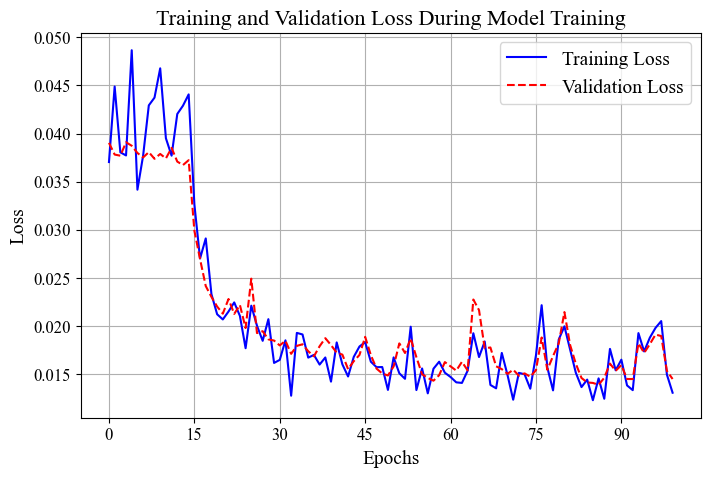

Epoch 99: 100%|██████████| 22/22 [00:21<00:00,  1.01it/s, v_num=100]


In [198]:
seq_length=288
embedding_dim = int(seq_length / 2)  # 嵌入向量的维度
teacher_forcing_ratio = 0  # 教师强制比率

model1_1 = AutoencoderGRU_2(
    seq_length=seq_length,
    input_dim=1,
    embedding_dim=embedding_dim,
    teacher_forcing_ratio=teacher_forcing_ratio
)

trainer1_1 = get_trainer("ex1_1")
# 开始训练
trainer1_1.fit(model1_1, train_A_loader_288, val_A_loader_288)

### 1-2

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | encoder | Encoder      | 438 K  | train
1 | decoder | Decoder_2    | 438 K  | train
2 | loss_fn | CombinedLoss | 0      | train
-------------------------------------------------
877 K     Trainable params
0         Non-trainable params
877 K     Total params
3.511     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 22/22 [00:14<00:00,  1.53it/s, v_num=101]       

`Trainer.fit` stopped: `max_epochs=100` reached.


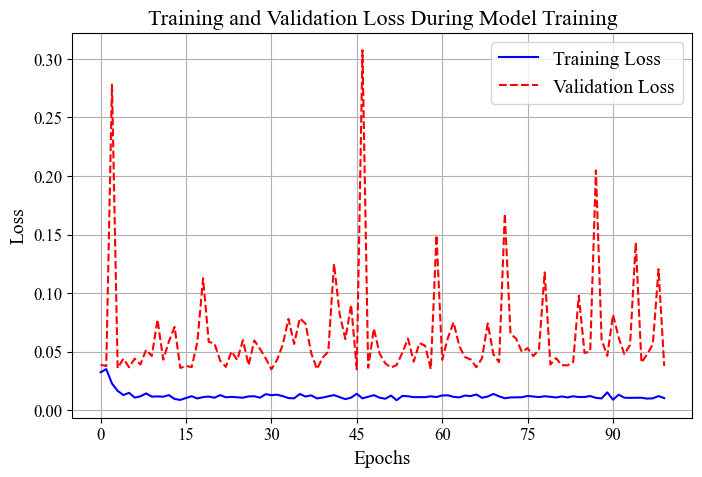

Epoch 99: 100%|██████████| 22/22 [00:14<00:00,  1.50it/s, v_num=101]


In [199]:
seq_length=288
embedding_dim = int(seq_length / 2)  # 嵌入向量的维度
teacher_forcing_ratio = 0.25  # 教师强制比率

model1_2 = AutoencoderGRU_2(
    seq_length=seq_length,
    input_dim=1,
    embedding_dim=embedding_dim,
    teacher_forcing_ratio=teacher_forcing_ratio
)

trainer1_2 = get_trainer("ex1_2")
# 开始训练
trainer1_2.fit(model1_2, train_A_loader_288, val_A_loader_288)

### 1-3

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | encoder | Encoder      | 438 K  | train
1 | decoder | Decoder_2    | 438 K  | train
2 | loss_fn | CombinedLoss | 0      | train
-------------------------------------------------
877 K     Trainable params
0         Non-trainable params
877 K     Total params
3.511     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 22/22 [00:15<00:00,  1.44it/s, v_num=102]       

`Trainer.fit` stopped: `max_epochs=100` reached.


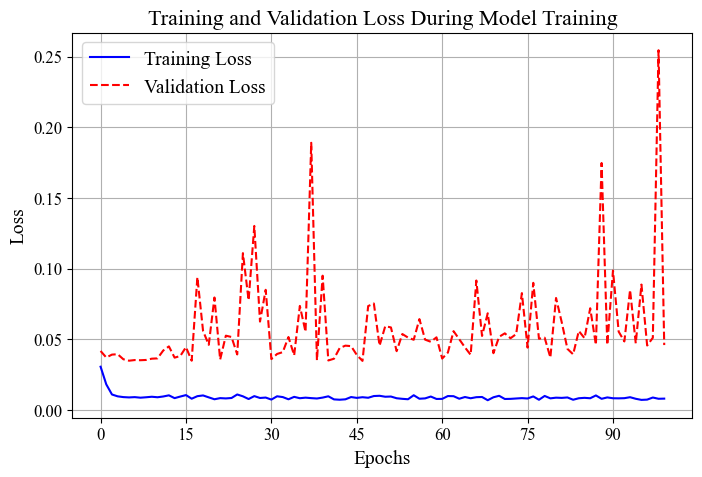

Epoch 99: 100%|██████████| 22/22 [00:15<00:00,  1.41it/s, v_num=102]


In [200]:
seq_length=288
embedding_dim = int(seq_length / 2)  # 嵌入向量的维度
teacher_forcing_ratio = 0.5  # 教师强制比率

model1_3 = AutoencoderGRU_2(
    seq_length=seq_length,
    input_dim=1,
    embedding_dim=embedding_dim,
    teacher_forcing_ratio=teacher_forcing_ratio
)

trainer1_3 = get_trainer("ex1_3")
# 开始训练
trainer1_3.fit(model1_3, train_A_loader_288, val_A_loader_288)

### 1-4

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | encoder | Encoder      | 438 K  | train
1 | decoder | Decoder_2    | 438 K  | train
2 | loss_fn | CombinedLoss | 0      | train
-------------------------------------------------
877 K     Trainable params
0         Non-trainable params
877 K     Total params
3.511     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 22/22 [00:15<00:00,  1.43it/s, v_num=103]       

`Trainer.fit` stopped: `max_epochs=100` reached.


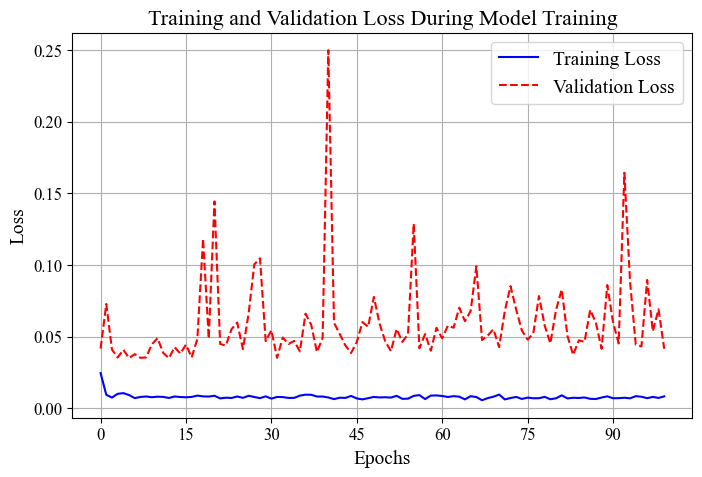

Epoch 99: 100%|██████████| 22/22 [00:15<00:00,  1.40it/s, v_num=103]


In [201]:
seq_length=288
embedding_dim = int(seq_length / 2)  # 嵌入向量的维度
teacher_forcing_ratio = 0.75  # 教师强制比率

model1_4 = AutoencoderGRU_2(
    seq_length=seq_length,
    input_dim=1,
    embedding_dim=embedding_dim,
    teacher_forcing_ratio=teacher_forcing_ratio
)

trainer1_4 = get_trainer("ex1_4")
# 开始训练
trainer1_4.fit(model1_4, train_A_loader_288, val_A_loader_288)

### 1-5

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | encoder | Encoder      | 438 K  | train
1 | decoder | Decoder_2    | 438 K  | train
2 | loss_fn | CombinedLoss | 0      | train
-------------------------------------------------
877 K     Trainable params
0         Non-trainable params
877 K     Total params
3.511     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 22/22 [00:15<00:00,  1.45it/s, v_num=104]       

`Trainer.fit` stopped: `max_epochs=100` reached.


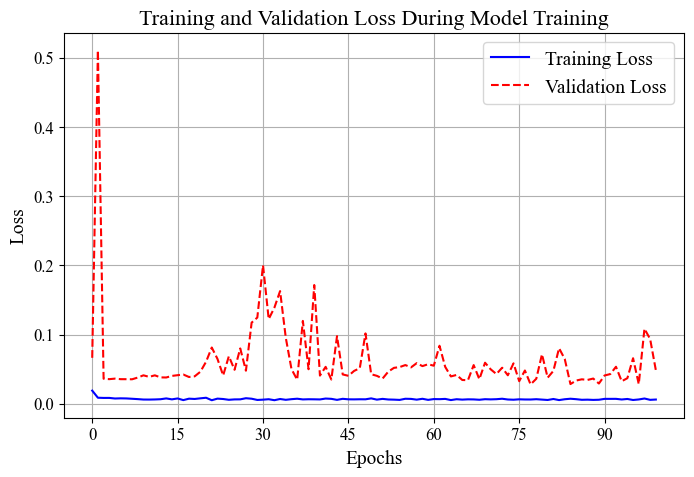

Epoch 99: 100%|██████████| 22/22 [00:15<00:00,  1.42it/s, v_num=104]


In [202]:
seq_length=288
embedding_dim = int(seq_length / 2)  # 嵌入向量的维度
teacher_forcing_ratio = 1  # 教师强制比率

model1_5 = AutoencoderGRU_2(
    seq_length=seq_length,
    input_dim=1,
    embedding_dim=embedding_dim,
    teacher_forcing_ratio=teacher_forcing_ratio
)

trainer1_5 = get_trainer("ex1_5")
# 开始训练
trainer1_5.fit(model1_5, train_A_loader_288, val_A_loader_288)

### 1-6

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | encoder | Encoder      | 438 K  | train
1 | decoder | Decoder_2    | 438 K  | train
2 | loss_fn | CombinedLoss | 0      | train
-------------------------------------------------
877 K     Trainable params
0         Non-trainable params
877 K     Total params
3.511     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 18/18 [00:11<00:00,  1.54it/s, v_num=105]       

`Trainer.fit` stopped: `max_epochs=100` reached.


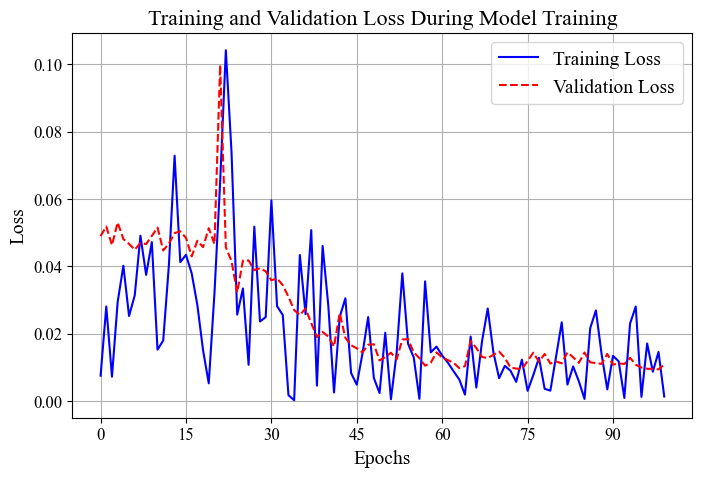

Epoch 99: 100%|██████████| 18/18 [00:12<00:00,  1.49it/s, v_num=105]


In [203]:
seq_length=288
embedding_dim = int(seq_length / 2)  # 嵌入向量的维度
teacher_forcing_ratio = 0  # 教师强制比率

model1_6 = AutoencoderGRU_2(
    seq_length=seq_length,
    input_dim=1,
    embedding_dim=embedding_dim,
    teacher_forcing_ratio=teacher_forcing_ratio
)

trainer1_6 = get_trainer("ex1_6")
# 开始训练
trainer1_6.fit(model1_6, train_B_loader_288, val_B_loader_288)

### 1-7

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | encoder | Encoder      | 438 K  | train
1 | decoder | Decoder_2    | 438 K  | train
2 | loss_fn | CombinedLoss | 0      | train
-------------------------------------------------
877 K     Trainable params
0         Non-trainable params
877 K     Total params
3.511     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 18/18 [00:12<00:00,  1.49it/s, v_num=106]       

`Trainer.fit` stopped: `max_epochs=100` reached.


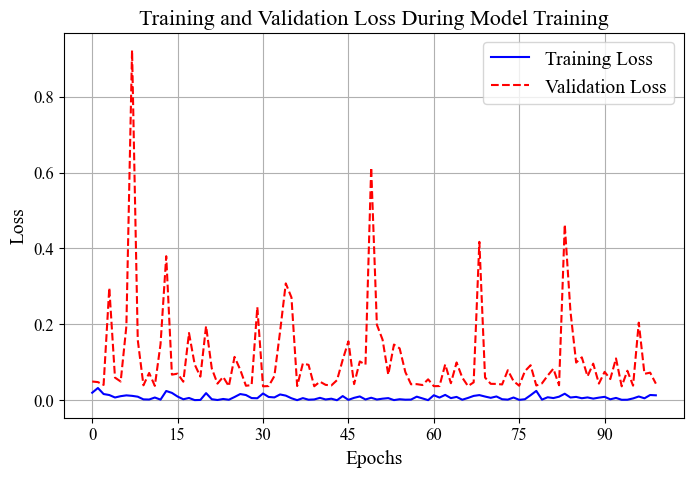

Epoch 99: 100%|██████████| 18/18 [00:12<00:00,  1.46it/s, v_num=106]


In [204]:
seq_length=288
embedding_dim = int(seq_length / 2)  # 嵌入向量的维度
teacher_forcing_ratio = 0.25  # 教师强制比率

model1_7 = AutoencoderGRU_2(
    seq_length=seq_length,
    input_dim=1,
    embedding_dim=embedding_dim,
    teacher_forcing_ratio=teacher_forcing_ratio
)

trainer1_7 = get_trainer("ex1_7")
# 开始训练
trainer1_7.fit(model1_7, train_B_loader_288, val_B_loader_288)

### 1-8

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | encoder | Encoder      | 438 K  | train
1 | decoder | Decoder_2    | 438 K  | train
2 | loss_fn | CombinedLoss | 0      | train
-------------------------------------------------
877 K     Trainable params
0         Non-trainable params
877 K     Total params
3.511     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 18/18 [00:14<00:00,  1.24it/s, v_num=107]       

`Trainer.fit` stopped: `max_epochs=100` reached.


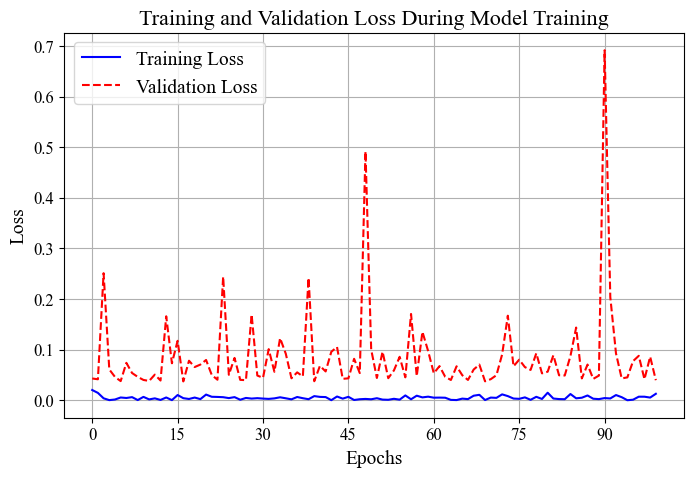

Epoch 99: 100%|██████████| 18/18 [00:14<00:00,  1.20it/s, v_num=107]


In [205]:
seq_length=288
embedding_dim = int(seq_length / 2)  # 嵌入向量的维度
teacher_forcing_ratio = 0.5  # 教师强制比率

model1_8 = AutoencoderGRU_2(
    seq_length=seq_length,
    input_dim=1,
    embedding_dim=embedding_dim,
    teacher_forcing_ratio=teacher_forcing_ratio
)

trainer1_8 = get_trainer("ex1_8")
# 开始训练
trainer1_8.fit(model1_8, train_B_loader_288, val_B_loader_288)

### 1-9

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | encoder | Encoder      | 438 K  | train
1 | decoder | Decoder_2    | 438 K  | train
2 | loss_fn | CombinedLoss | 0      | train
-------------------------------------------------
877 K     Trainable params
0         Non-trainable params
877 K     Total params
3.511     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 18/18 [00:12<00:00,  1.45it/s, v_num=108]       

`Trainer.fit` stopped: `max_epochs=100` reached.


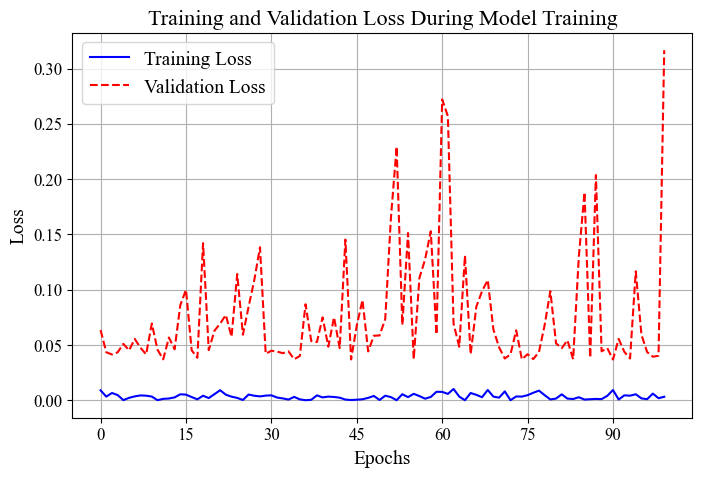

Epoch 99: 100%|██████████| 18/18 [00:12<00:00,  1.42it/s, v_num=108]


In [206]:
seq_length=288
embedding_dim = int(seq_length / 2)  # 嵌入向量的维度
teacher_forcing_ratio = 0.75  # 教师强制比率

model1_9 = AutoencoderGRU_2(
    seq_length=seq_length,
    input_dim=1,
    embedding_dim=embedding_dim,
    teacher_forcing_ratio=teacher_forcing_ratio
)

trainer1_9 = get_trainer("ex1_9")
# 开始训练
trainer1_9.fit(model1_9, train_B_loader_288, val_B_loader_288)

### 1-10

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | encoder | Encoder      | 438 K  | train
1 | decoder | Decoder_2    | 438 K  | train
2 | loss_fn | CombinedLoss | 0      | train
-------------------------------------------------
877 K     Trainable params
0         Non-trainable params
877 K     Total params
3.511     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 18/18 [00:12<00:00,  1.44it/s, v_num=109]       

`Trainer.fit` stopped: `max_epochs=100` reached.


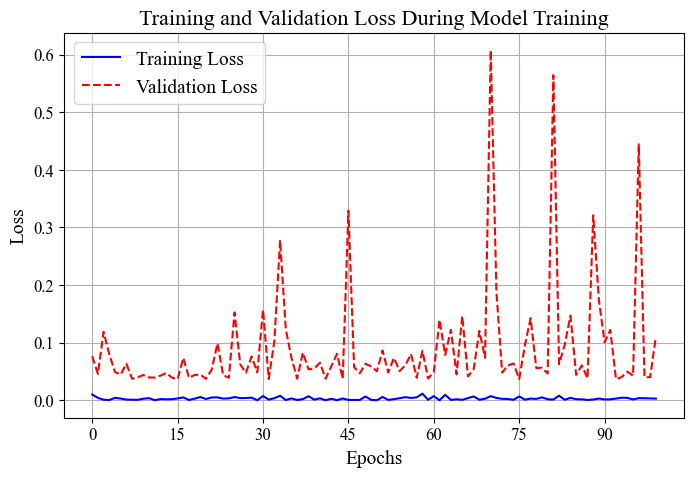

Epoch 99: 100%|██████████| 18/18 [00:12<00:00,  1.40it/s, v_num=109]


In [207]:
seq_length=288
embedding_dim = int(seq_length / 2)  # 嵌入向量的维度
teacher_forcing_ratio = 0.9  # 教师强制比率

model1_10 = AutoencoderGRU_2(
    seq_length=seq_length,
    input_dim=1,
    embedding_dim=embedding_dim,
    teacher_forcing_ratio=teacher_forcing_ratio
)

trainer1_10 = get_trainer("ex1_10")
# 开始训练
trainer1_10.fit(model1_10, train_B_loader_288, val_B_loader_288)

### dump loss

In [208]:
experiment_1_loss = [model1_1.train_losses, model1_1.val_losses,
                     model1_2.train_losses, model1_2.val_losses,
                     model1_3.train_losses, model1_3.val_losses,
                     model1_4.train_losses, model1_4.val_losses,
                     model1_5.train_losses, model1_5.val_losses,
                     model1_6.train_losses, model1_6.val_losses,
                     model1_7.train_losses, model1_7.val_losses,
                     model1_8.train_losses, model1_8.val_losses,
                     model1_9.train_losses, model1_9.val_losses,
                     model1_10.train_losses, model1_10.val_losses]

# 保存列表到本地文件
with open('experiment_1_loss.pkl', 'wb') as f:
    pickle.dump(experiment_1_loss, f)

## II. window size
| 实验编号 | 数据集编号 | **数据集细节**          | 模型   |
| ---- | ----- | ------------------ | ---- |
| 2-1  | A     | **窗口大小144，重叠度75%** | 自由运行 |
| 2-2  | A     | **窗口大小216，重叠度75%** | 自由运行 |
| 2-3  | A     | **窗口大小288，重叠度75%** | 自由运行 |
| 2-4  | A     | **窗口大小360，重叠度75%** | 自由运行 |
| 2-5  | A     | **窗口大小432，重叠度75%** | 自由运行 |
| 2-6  | B     | **窗口大小144，重叠度75%** | 自由运行 |
| 2-7  | B     | **窗口大小216，重叠度75%** | 自由运行 |
| 2-8  | B     | **窗口大小288，重叠度75%** | 自由运行 |
| 2-9  | B     | **窗口大小360，重叠度75%** | 自由运行 |
| 2-10 | B     | **窗口大小432，重叠度75%** | 自由运行 |

In [209]:
# 窗口长度 288
train_A_loader_288 = get_loader(data=train_A, batch_size=32, sub_length=288, ratio=0.75)
train_B_loader_288 = get_loader(data=train_B, batch_size=32, sub_length=288, ratio=0.75)

val_A_loader_288 = get_loader(data=valid_A, batch_size=32, sub_length=288, ratio=0.75, shuffle=False)
val_B_loader_288 = get_loader(data=valid_B, batch_size=32, sub_length=288, ratio=0.75, shuffle=False)

# 窗口长度144
train_A_loader_144 = get_loader(data=train_A, batch_size=32, sub_length=144, ratio=0.75)
train_B_loader_144 = get_loader(data=train_B, batch_size=32, sub_length=144, ratio=0.75)

val_A_loader_144 = get_loader(data=valid_A, batch_size=32, sub_length=144, ratio=0.75, shuffle=False)
val_B_loader_144 = get_loader(data=valid_B, batch_size=32, sub_length=144, ratio=0.75, shuffle=False)

# 窗口长度216
train_A_loader_216 = get_loader(data=train_A, batch_size=32, sub_length=216, ratio=0.75)
train_B_loader_216 = get_loader(data=train_B, batch_size=32, sub_length=216, ratio=0.75)

val_A_loader_216 = get_loader(data=valid_A, batch_size=32, sub_length=216, ratio=0.75, shuffle=False)
val_B_loader_216 = get_loader(data=valid_B, batch_size=32, sub_length=216, ratio=0.75, shuffle=False)

# 窗口长度360
train_A_loader_360 = get_loader(data=train_A, batch_size=32, sub_length=360, ratio=0.75)
train_B_loader_360 = get_loader(data=train_B, batch_size=32, sub_length=360, ratio=0.75)

val_A_loader_360 = get_loader(data=valid_A, batch_size=32, sub_length=360, ratio=0.75, shuffle=False)
val_B_loader_360 = get_loader(data=valid_B, batch_size=32, sub_length=360, ratio=0.75, shuffle=False)

# 窗口长度432
train_A_loader_432 = get_loader(data=train_A, batch_size=32, sub_length=432, ratio=0.75)
train_B_loader_432 = get_loader(data=train_B, batch_size=32, sub_length=432, ratio=0.75)

val_A_loader_432 = get_loader(data=valid_A, batch_size=32, sub_length=432, ratio=0.75, shuffle=False)
val_B_loader_432 = get_loader(data=valid_B, batch_size=32, sub_length=432, ratio=0.75, shuffle=False)


### 2-1

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | encoder | Encoder      | 110 K  | train
1 | decoder | Decoder_2    | 110 K  | train
2 | loss_fn | CombinedLoss | 0      | train
-------------------------------------------------
221 K     Trainable params
0         Non-trainable params
221 K     Total params
0.884     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 45/45 [00:14<00:00,  3.10it/s, v_num=110]       

`Trainer.fit` stopped: `max_epochs=100` reached.


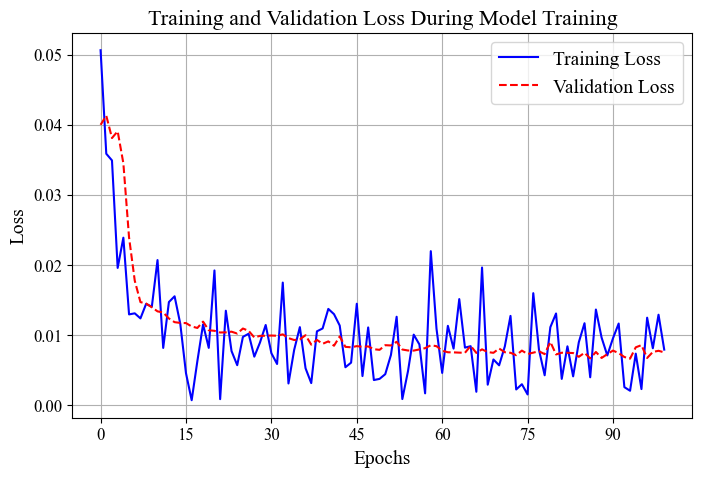

Epoch 99: 100%|██████████| 45/45 [00:14<00:00,  3.03it/s, v_num=110]


In [210]:
seq_length=144
embedding_dim = int(seq_length / 2)  # 嵌入向量的维度
teacher_forcing_ratio = 0  # 教师强制比率

model2_1 = AutoencoderGRU_2(
    seq_length=seq_length,
    input_dim=1,
    embedding_dim=embedding_dim,
    teacher_forcing_ratio=teacher_forcing_ratio,
    alpha=0.5
)

trainer2_1 = get_trainer("ex2_1")
# 开始训练
trainer2_1.fit(model2_1, train_A_loader_144, val_A_loader_144)

### 2-2

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | encoder | Encoder      | 247 K  | train
1 | decoder | Decoder_2    | 247 K  | train
2 | loss_fn | CombinedLoss | 0      | train
-------------------------------------------------
494 K     Trainable params
0         Non-trainable params
494 K     Total params
1.980     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 30/30 [00:14<00:00,  2.03it/s, v_num=111]       

`Trainer.fit` stopped: `max_epochs=100` reached.


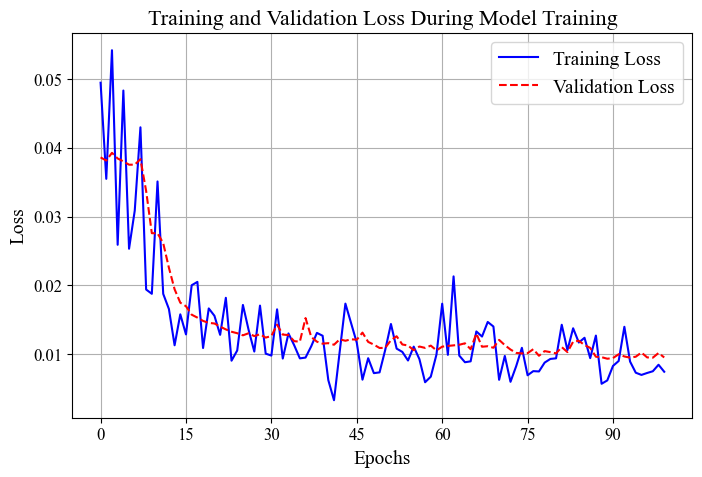

Epoch 99: 100%|██████████| 30/30 [00:15<00:00,  1.99it/s, v_num=111]


In [211]:
seq_length = 216
embedding_dim = int(seq_length / 2)  # 嵌入向量的维度
teacher_forcing_ratio = 0  # 教师强制比率

model2_2 = AutoencoderGRU_2(
    seq_length=seq_length,
    input_dim=1,
    embedding_dim=embedding_dim,
    teacher_forcing_ratio=teacher_forcing_ratio
)

trainer2_2 = get_trainer("ex2_2")
# 开始训练
trainer2_2.fit(model2_2, train_A_loader_216, val_A_loader_216)

### 2-3

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | encoder | Encoder      | 438 K  | train
1 | decoder | Decoder_2    | 438 K  | train
2 | loss_fn | CombinedLoss | 0      | train
-------------------------------------------------
877 K     Trainable params
0         Non-trainable params
877 K     Total params
3.511     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 22/22 [00:14<00:00,  1.55it/s, v_num=112]       

`Trainer.fit` stopped: `max_epochs=100` reached.


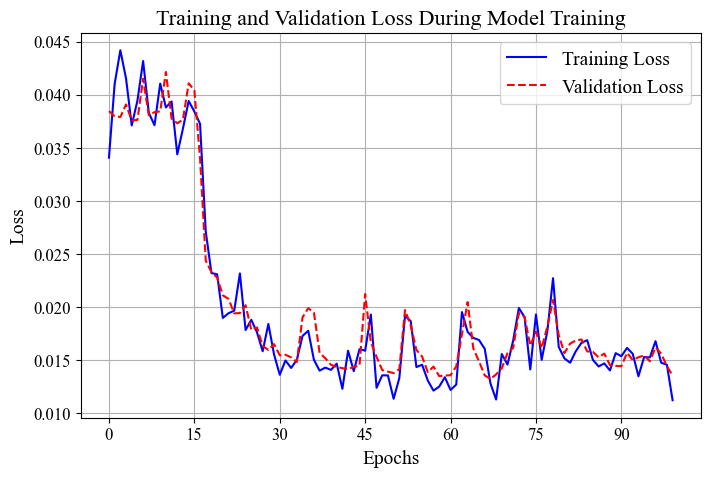

Epoch 99: 100%|██████████| 22/22 [00:14<00:00,  1.51it/s, v_num=112]


In [212]:
seq_length = 288
embedding_dim = int(seq_length / 2)  # 嵌入向量的维度
teacher_forcing_ratio = 0  # 教师强制比率

model2_3 = AutoencoderGRU_2(
    seq_length=seq_length,
    input_dim=1,
    embedding_dim=embedding_dim,
    teacher_forcing_ratio=teacher_forcing_ratio
)

trainer2_3 = get_trainer("ex2_3")
# 开始训练
trainer2_3.fit(model2_3, train_A_loader_288, val_A_loader_288)


### 2-4

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | encoder | Encoder      | 684 K  | train
1 | decoder | Decoder_2    | 684 K  | train
2 | loss_fn | CombinedLoss | 0      | train
-------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.477     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 18/18 [00:15<00:00,  1.19it/s, v_num=113]       

`Trainer.fit` stopped: `max_epochs=100` reached.


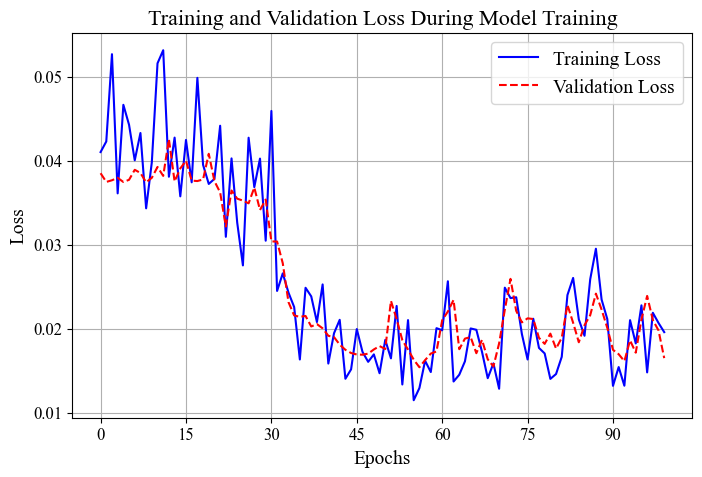

Epoch 99: 100%|██████████| 18/18 [00:15<00:00,  1.17it/s, v_num=113]


In [213]:
seq_length = 360
embedding_dim = int(seq_length / 2)  # 嵌入向量的维度
teacher_forcing_ratio = 0  # 教师强制比率

model2_4 = AutoencoderGRU_2(
    seq_length=seq_length,
    input_dim=1,
    embedding_dim=embedding_dim,
    teacher_forcing_ratio=teacher_forcing_ratio
)

trainer2_4 = get_trainer("ex2_4")
# 开始训练
trainer2_4.fit(model2_4, train_A_loader_360, val_A_loader_360)


### 2-5

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | encoder | Encoder      | 984 K  | train
1 | decoder | Decoder_2    | 984 K  | train
2 | loss_fn | CombinedLoss | 0      | train
-------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.879     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 15/15 [00:15<00:00,  0.95it/s, v_num=114]       

`Trainer.fit` stopped: `max_epochs=100` reached.


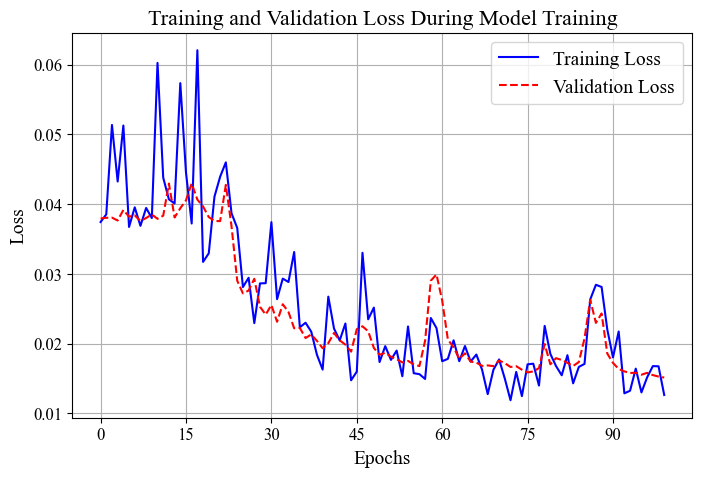

Epoch 99: 100%|██████████| 15/15 [00:16<00:00,  0.92it/s, v_num=114]


In [214]:
seq_length = 432
embedding_dim = int(seq_length / 2)  # 嵌入向量的维度
teacher_forcing_ratio = 0  # 教师强制比率

model2_5 = AutoencoderGRU_2(
    seq_length=seq_length,
    input_dim=1,
    embedding_dim=embedding_dim,
    teacher_forcing_ratio=teacher_forcing_ratio
)

trainer2_5 = get_trainer("ex2_5")
# 开始训练
trainer2_5.fit(model2_5, train_A_loader_432, val_A_loader_432)


### 2-6

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | encoder | Encoder      | 110 K  | train
1 | decoder | Decoder_2    | 110 K  | train
2 | loss_fn | CombinedLoss | 0      | train
-------------------------------------------------
221 K     Trainable params
0         Non-trainable params
221 K     Total params
0.884     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 36/36 [00:11<00:00,  3.21it/s, v_num=115]       

`Trainer.fit` stopped: `max_epochs=100` reached.


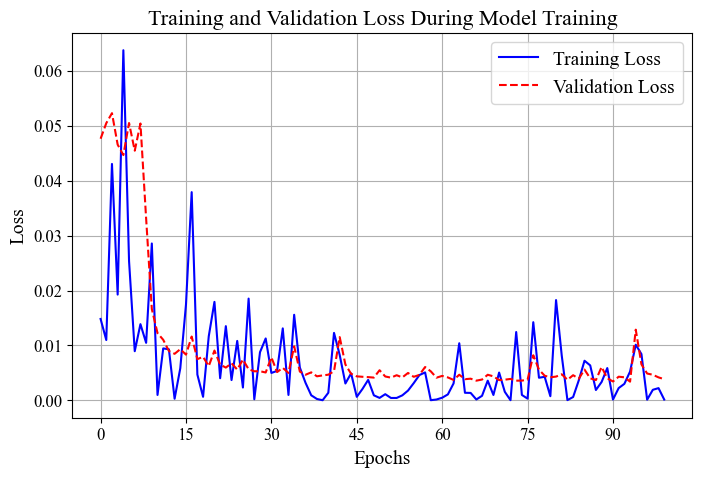

Epoch 99: 100%|██████████| 36/36 [00:11<00:00,  3.12it/s, v_num=115]


In [215]:
seq_length = 144
embedding_dim = int(seq_length / 2)  # 嵌入向量的维度
teacher_forcing_ratio = 0  # 教师强制比率

model2_6 = AutoencoderGRU_2(
    seq_length=seq_length,
    input_dim=1,
    embedding_dim=embedding_dim,
    teacher_forcing_ratio=teacher_forcing_ratio
)

trainer2_6 = get_trainer("ex2_6")
# 开始训练
trainer2_6.fit(model2_6, train_B_loader_144, val_B_loader_144)


### 2-7

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | encoder | Encoder      | 247 K  | train
1 | decoder | Decoder_2    | 247 K  | train
2 | loss_fn | CombinedLoss | 0      | train
-------------------------------------------------
494 K     Trainable params
0         Non-trainable params
494 K     Total params
1.980     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 24/24 [00:12<00:00,  1.90it/s, v_num=116]       

`Trainer.fit` stopped: `max_epochs=100` reached.


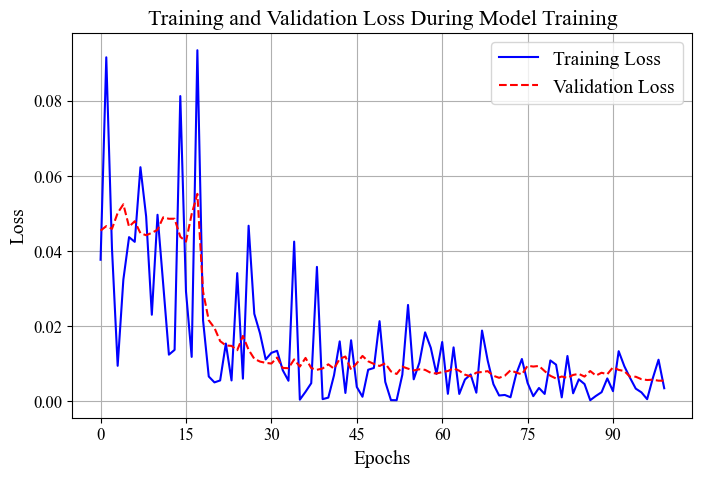

Epoch 99: 100%|██████████| 24/24 [00:12<00:00,  1.85it/s, v_num=116]


In [216]:
seq_length = 216
embedding_dim = int(seq_length / 2)  # 嵌入向量的维度
teacher_forcing_ratio = 0  # 教师强制比率

model2_7 = AutoencoderGRU_2(
    seq_length=seq_length,
    input_dim=1,
    embedding_dim=embedding_dim,
    teacher_forcing_ratio=teacher_forcing_ratio
)

trainer2_7 = get_trainer("ex2_7")
# 开始训练
trainer2_7.fit(model2_7, train_B_loader_216, val_B_loader_216)


### 2-8

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | encoder | Encoder      | 438 K  | train
1 | decoder | Decoder_2    | 438 K  | train
2 | loss_fn | CombinedLoss | 0      | train
-------------------------------------------------
877 K     Trainable params
0         Non-trainable params
877 K     Total params
3.511     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 18/18 [00:11<00:00,  1.52it/s, v_num=117]       

`Trainer.fit` stopped: `max_epochs=100` reached.


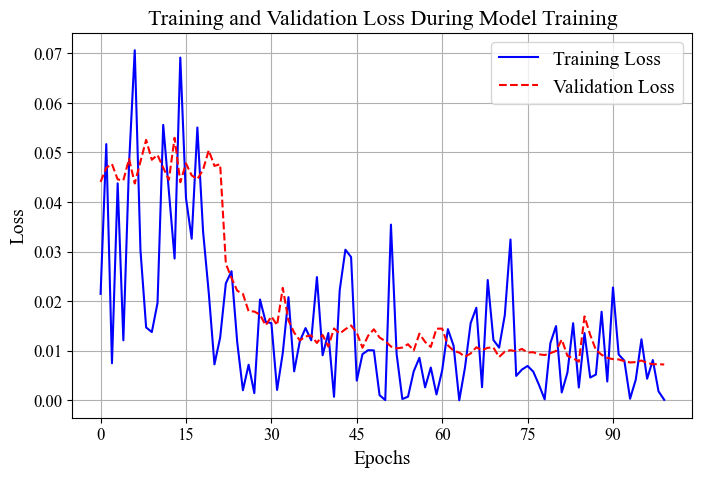

Epoch 99: 100%|██████████| 18/18 [00:12<00:00,  1.47it/s, v_num=117]


In [217]:
seq_length = 288
embedding_dim = int(seq_length / 2)  # 嵌入向量的维度
teacher_forcing_ratio = 0  # 教师强制比率

model2_8 = AutoencoderGRU_2(
    seq_length=seq_length,
    input_dim=1,
    embedding_dim=embedding_dim,
    teacher_forcing_ratio=teacher_forcing_ratio
)

trainer2_8 = get_trainer("ex2_8")
# 开始训练
trainer2_8.fit(model2_8, train_B_loader_288, val_B_loader_288)


### 2-9

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | encoder | Encoder      | 684 K  | train
1 | decoder | Decoder_2    | 684 K  | train
2 | loss_fn | CombinedLoss | 0      | train
-------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.477     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 14/14 [00:11<00:00,  1.25it/s, v_num=118]       

`Trainer.fit` stopped: `max_epochs=100` reached.


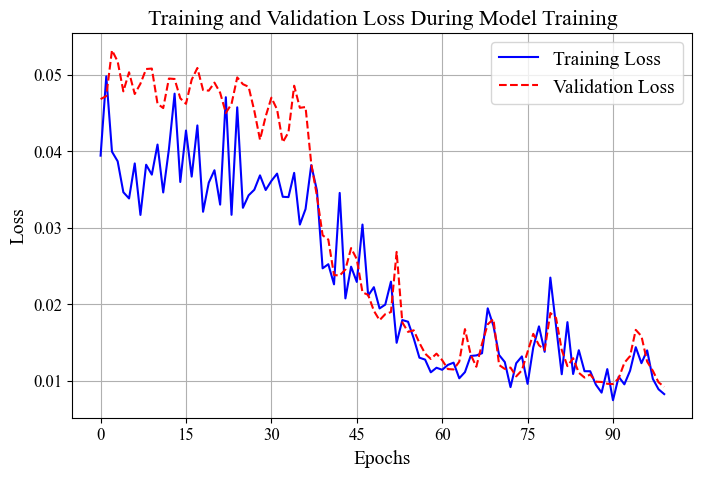

Epoch 99: 100%|██████████| 14/14 [00:11<00:00,  1.21it/s, v_num=118]


In [218]:
seq_length = 360
embedding_dim = int(seq_length / 2)  # 嵌入向量的维度
teacher_forcing_ratio = 0  # 教师强制比率

model2_9 = AutoencoderGRU_2(
    seq_length=seq_length,
    input_dim=1,
    embedding_dim=embedding_dim,
    teacher_forcing_ratio=teacher_forcing_ratio
)

trainer2_9 = get_trainer("ex2_9")
# 开始训练
trainer2_9.fit(model2_9, train_B_loader_360, val_B_loader_360)


### 2-10

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params | Mode 
-------------------------------------------------
0 | encoder | Encoder      | 984 K  | train
1 | decoder | Decoder_2    | 984 K  | train
2 | loss_fn | CombinedLoss | 0      | train
-------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.879     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 12/12 [00:12<00:00,  0.95it/s, v_num=119]       

`Trainer.fit` stopped: `max_epochs=100` reached.


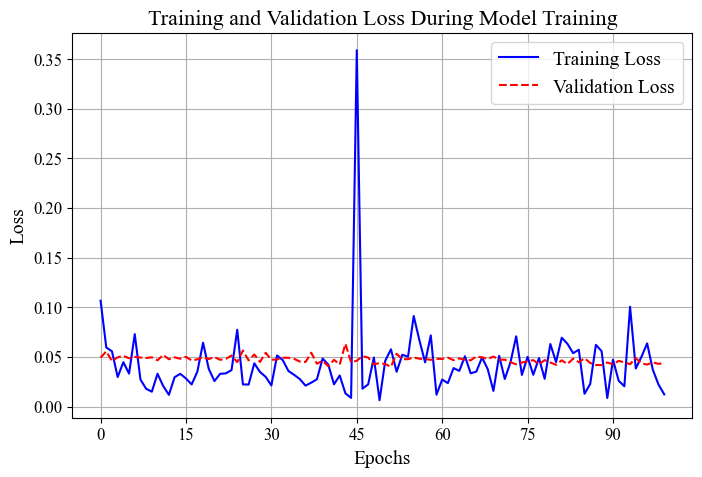

Epoch 99: 100%|██████████| 12/12 [00:12<00:00,  0.92it/s, v_num=119]


In [219]:
seq_length = 432
embedding_dim = int(seq_length / 2)  # 嵌入向量的维度
teacher_forcing_ratio = 0  # 教师强制比率

model2_10 = AutoencoderGRU_2(
    seq_length=seq_length,
    input_dim=1,
    embedding_dim=embedding_dim,
    teacher_forcing_ratio=teacher_forcing_ratio
)

trainer2_10 = get_trainer("ex2_10")
# 开始训练
trainer2_10.fit(model2_10, train_B_loader_432, val_B_loader_432)


### dump loss

In [220]:
experiment_2_loss = [model2_1.train_losses, model2_1.val_losses,
                     model2_2.train_losses, model2_2.val_losses,
                     model2_3.train_losses, model2_3.val_losses,
                     model2_4.train_losses, model2_4.val_losses,
                     model2_5.train_losses, model2_5.val_losses,
                     model2_6.train_losses, model2_6.val_losses,
                     model2_7.train_losses, model2_7.val_losses,
                     model2_8.train_losses, model2_8.val_losses,
                     model2_9.train_losses, model2_9.val_losses,
                     model2_10.train_losses, model2_10.val_losses]

# 保存列表到本地文件
with open('experiment_2_loss.pkl', 'wb') as f:
    pickle.dump(experiment_2_loss, f)

# 6. Result

## I. Dataset A

In [256]:
print(np.array(model2_1.train_losses).mean())
print(np.array(model2_1.train_losses).std())

0.009993348002899438
0.007432170408685299


In [257]:
test_A_loader_144 = get_loader(data=test_A, batch_size=32, sub_length=144, ratio=0.75, shuffle=False)
test_B_loader_144 = get_loader(data=test_B, batch_size=32, sub_length=144, ratio=0.75, shuffle=False)

Average training loss: 0.007462
Average validation loss: 0.007512


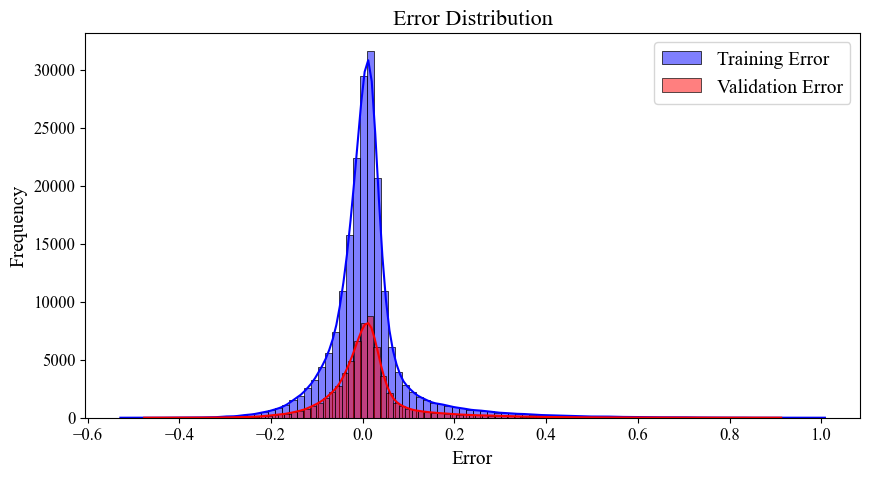

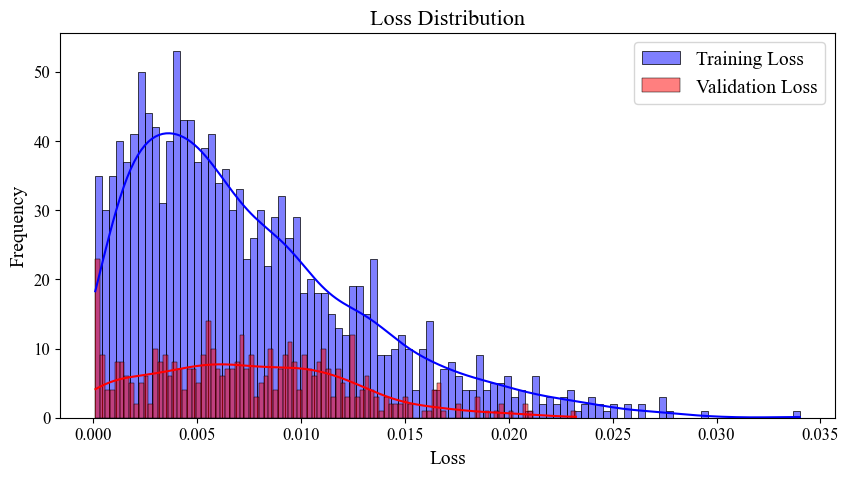

Mean of training predictions: 0.6433, Standard deviation: 0.2639
Mean of validation predictions: 0.6782, Standard deviation: 0.2481


In [286]:
# Initialize the loss function, alpha is the same as during training  
loss_fn = CombinedLoss(alpha=0.5)  

# Modify the loss function to return the loss for each sample  
class CombinedLossPerSample(nn.Module):  
    def __init__(self, alpha=0.5):  
        super(CombinedLossPerSample, self).__init__()  
        self.alpha = alpha  
        self.mse_loss = nn.MSELoss(reduction='none')  

    def forward(self, y_true, y_pred):  
        # Compute MSE loss for each sample  
        mse = self.mse_loss(y_true, y_pred).mean(dim=[1, 2])  # Average over sequence length and feature dimensions  
        # Compute fluctuation-sensitive loss  
        delta_true = y_true[:, 1:] - y_true[:, :-1]  # Rate of change for true values  
        delta_pred = y_pred[:, 1:] - y_pred[:, :-1]  # Rate of change for predicted values  
        fluctuation_loss = ((delta_true - delta_pred) ** 2).mean(dim=[1, 2])  
        # Compute combined loss  
        combined_loss = self.alpha * mse + (1 - self.alpha) * fluctuation_loss  
        return combined_loss  # Return the loss for each sample  

# Use the new loss function  
loss_fn = CombinedLossPerSample(alpha=0.5)  

# %%  
# Collect predictions, true values, and losses for the training set  
train_preds = []  
train_targets = []  
train_losses = []  

model2_1.eval()  # Set model to evaluation mode  
with torch.no_grad():  
    for batch in train_A_loader_144:  
        x = batch[0].to(model2_1.device)  
        pred = model2_1(x)  
        loss = loss_fn(pred, x)  # Loss for each sample  
        train_preds.append(pred.cpu())  
        train_targets.append(x.cpu())  
        train_losses.extend(loss.cpu().numpy())  # Add loss for each sample to the list  

# %%  
# Collect predictions, true values, and losses for the validation set  
val_preds = []  
val_targets = []  
val_losses = []  

with torch.no_grad():  
    for batch in val_A_loader_144:  
        x = batch[0].to(model2_1.device)  
        pred = model2_1(x)  
        loss = loss_fn(pred, x)  # Loss for each sample  
        val_preds.append(pred.cpu())  
        val_targets.append(x.cpu())  
        val_losses.extend(loss.cpu().numpy())  

# %%  
# Calculate the average loss  
avg_train_loss = np.mean(train_losses)  
avg_val_loss = np.mean(val_losses)  

print(f'Average training loss: {avg_train_loss:.6f}')  
print(f'Average validation loss: {avg_val_loss:.6f}')  

# %%  
# Concatenate the predictions and true values across batches  
train_preds = torch.cat(train_preds, dim=0)  
train_targets = torch.cat(train_targets, dim=0)  

val_preds = torch.cat(val_preds, dim=0)  
val_targets = torch.cat(val_targets, dim=0)  

# %%  
# Compute errors  
train_errors = (train_preds - train_targets).numpy()  
val_errors = (val_preds - val_targets).numpy()  

# Flatten errors to a one-dimensional array  
train_errors = train_errors.flatten()  
val_errors = val_errors.flatten()  

# %%  
# Plot error distribution  
import matplotlib.pyplot as plt  
import seaborn as sns  

plt.figure(figsize=(10, 5))  
sns.histplot(train_errors, bins=100, kde=True, color='blue', label='Training Error')  
sns.histplot(val_errors, bins=100, kde=True, color='red', label='Validation Error')  
plt.legend()  
plt.title('Error Distribution')  
plt.xlabel('Error')  
plt.ylabel('Frequency')
plt.savefig('Error Distribution.svg', dpi=300)  # 保存为高分辨率，适合打印  
plt.show()  

# %%  
# Plot loss distribution  
plt.figure(figsize=(10, 5))  
sns.histplot(train_losses, bins=100, kde=True, color='blue', label='Training Loss')  
sns.histplot(val_losses, bins=100, kde=True, color='red', label='Validation Loss')  
plt.legend()  
plt.title('Loss Distribution')  
plt.xlabel('Loss')  
plt.ylabel('Frequency')  
plt.savefig('Loss Distribution.svg', dpi=300)  # 保存为高分辨率，适合打印  
plt.show()  

# %%  
# Calculate the mean and standard deviation of predictions for the training and validation sets  
train_mean = train_preds.mean().item()  
train_std = train_preds.std().item()  

val_mean = val_preds.mean().item()  
val_std = val_preds.std().item()  

print(f'Mean of training predictions: {train_mean:.4f}, Standard deviation: {train_std:.4f}')  
print(f'Mean of validation predictions: {val_mean:.4f}, Standard deviation: {val_std:.4f}')

In [330]:

import numpy as np  
import matplotlib.pyplot as plt  
import torch  

# Define validation set mean and std dev of the loss  
mu_epsilon = 0.009993348002899438 
sigma_epsilon = 0.007432170408685299 

# Collect predictions, true values, and losses for the test set  
test_preds = []  
test_targets = []  

# Initialize the loss function, alpha is the same as during training  
loss_fn = CombinedLoss(alpha=0.5)  

model2_1.eval()  # Set model to evaluation mode  
with torch.no_grad():  
    for batch in test_A_loader_144:  
        x = batch[0].to(model2_1.device)  
        pred = model2_1(x)  
        test_preds.append(pred.cpu())  
        test_targets.append(x.cpu())  

# Concatenate predictions and true values across batches  
test_preds = torch.cat(test_preds, dim=0)  
test_targets = torch.cat(test_targets, dim=0)  

# Calculate per-time-point losses (using the same loss function as for training)  
errors = loss_fn(test_targets, test_preds).numpy()  

# Calculate anomaly probabilities for each time point  
anomaly_probabilities =  1 - np.exp(-0.5 * ((errors - mu_epsilon) / sigma_epsilon) ** 2) 

# Select the number of samples to plot  
num_examples = 5  # You can adjust this number as needed  

# Function to find contiguous anomaly regions
def find_anomaly_regions(anomaly_indices):
    if len(anomaly_indices) == 0:
        return []
    regions = []
    start = anomaly_indices[0]
    end = anomaly_indices[0]
    for idx in anomaly_indices[1:]:
        if idx == end + 1:
            end = idx
        else:
            regions.append((start, end))
            start = idx
            end = idx
    regions.append((start, end))
    return regions

def plot_result_A(i=1):
    plt.figure(figsize=(15, 10))  

    # Extract the i-th sample's input (true values), output (predicted values), and anomaly probabilities  
    input_seq = test_targets[i].numpy().flatten()  
    output_seq = test_preds[i].numpy().flatten()  
    anomaly_seq = anomaly_probabilities[i].flatten()  # Flatten the anomaly probabilities sequence  

    # Identify anomaly positions where anomaly probability > 0.8  
    anomaly_threshold = 0.8  
    anomaly_indices = np.where(anomaly_seq > anomaly_threshold)[0]  
    anomaly_regions = find_anomaly_regions(anomaly_indices)

    # Create a subplot structure with three rows and one column
    plt.subplot(3, 1, 1)  
    plt.plot(input_seq, label='Input Sequence', color='blue')  
    # Highlight anomaly regions on the input sequence  
    for start, end in anomaly_regions:
        plt.axvspan(start, end, color='red', alpha=0.3)
    plt.title(f'Test Sample {i+1} - Input Sequence')  
    plt.xlabel('Time Step')  
    plt.ylabel('Value')  
    plt.legend()  

    plt.subplot(3, 1, 2)  
    plt.plot(output_seq, label='Output Sequence', color='red')  
    plt.title(f'Test Sample {i+1} - Output Sequence')  
    plt.xlabel('Time Step')  
    plt.ylabel('Value')  
    plt.legend()  

    plt.subplot(3, 1, 3)  
    plt.plot(anomaly_seq, label='Anomaly Probability', color='green')  
    # Plot the anomaly probability threshold line  
    plt.axhline(y=anomaly_threshold, color='orange', linestyle='--', label='Threshold (0.8)')  
    # Highlight anomaly probabilities above the threshold  
    if len(anomaly_indices) > 0:  
        plt.scatter(anomaly_indices, anomaly_seq[anomaly_indices], color='red', label='Anomaly (>0.8)')  
    plt.title(f'Test Sample {i+1} - Anomaly Probability')  
    plt.xlabel('Time Step')  
    plt.ylabel('Probability')  
    plt.legend()  

    plt.tight_layout()  
    plt.savefig(f'Test Sample {i+1} - Anomaly Probability.svg', dpi=300)
    plt.show()

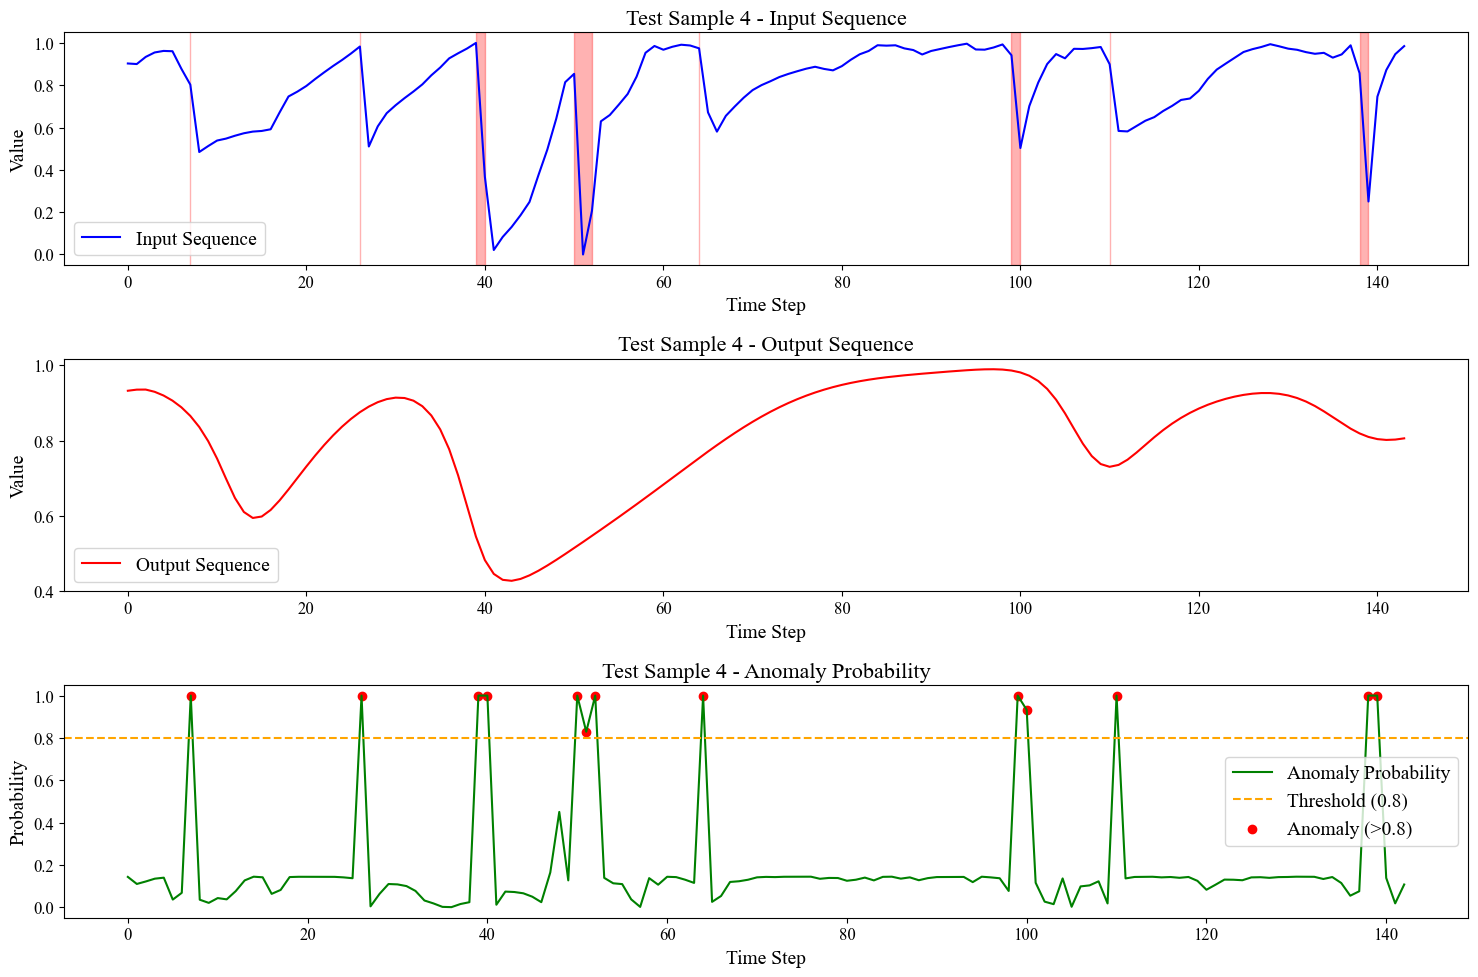

In [331]:
plot_result_A(3)

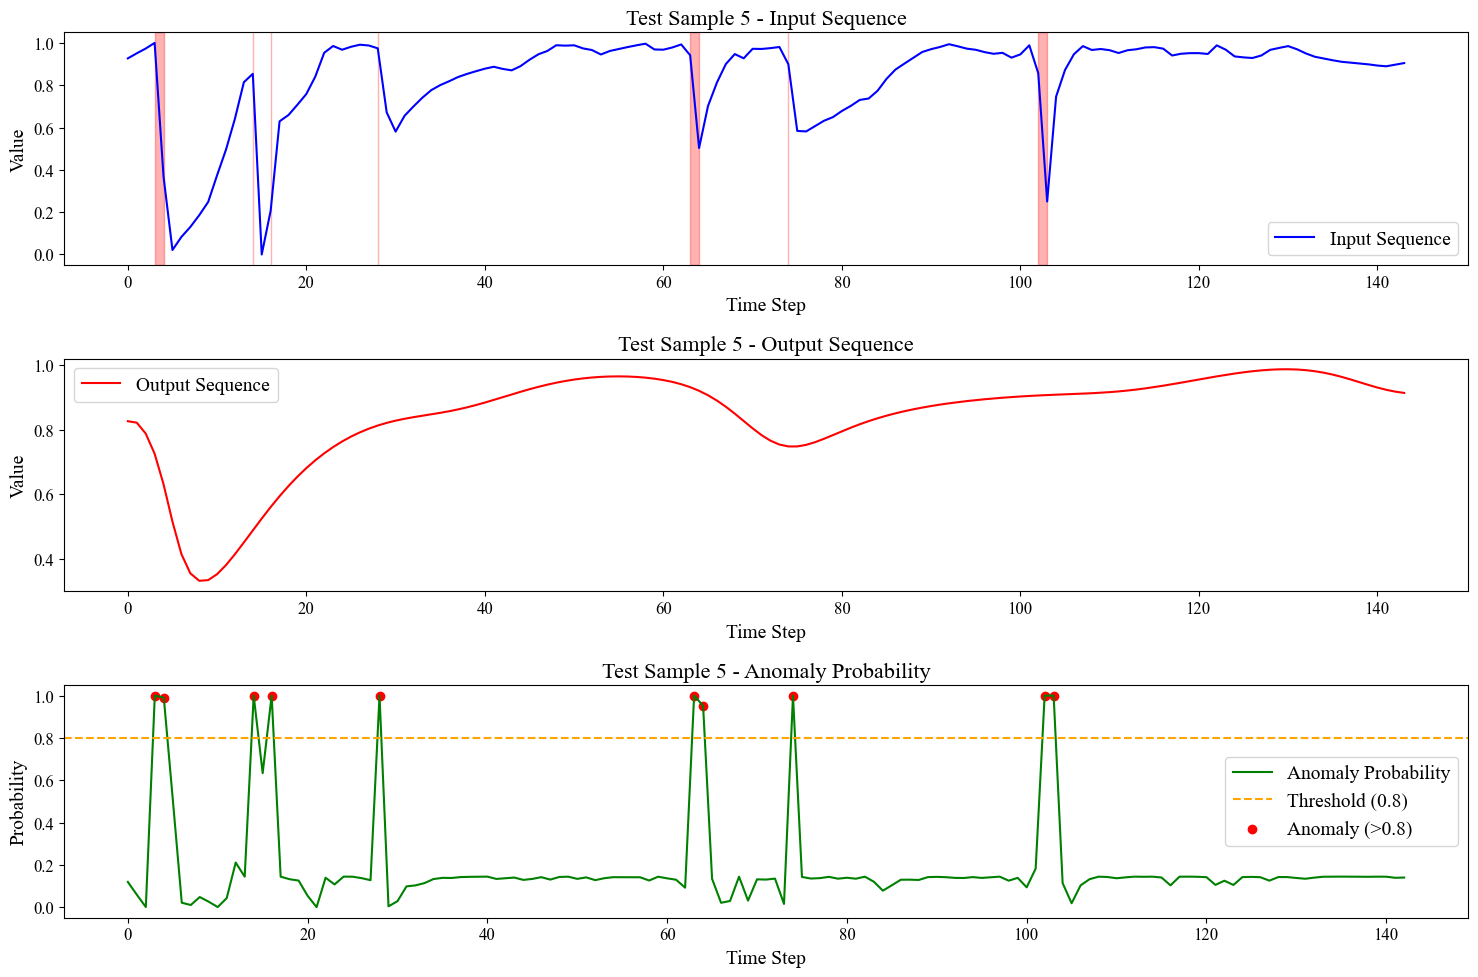

In [332]:
plot_result_A(4)

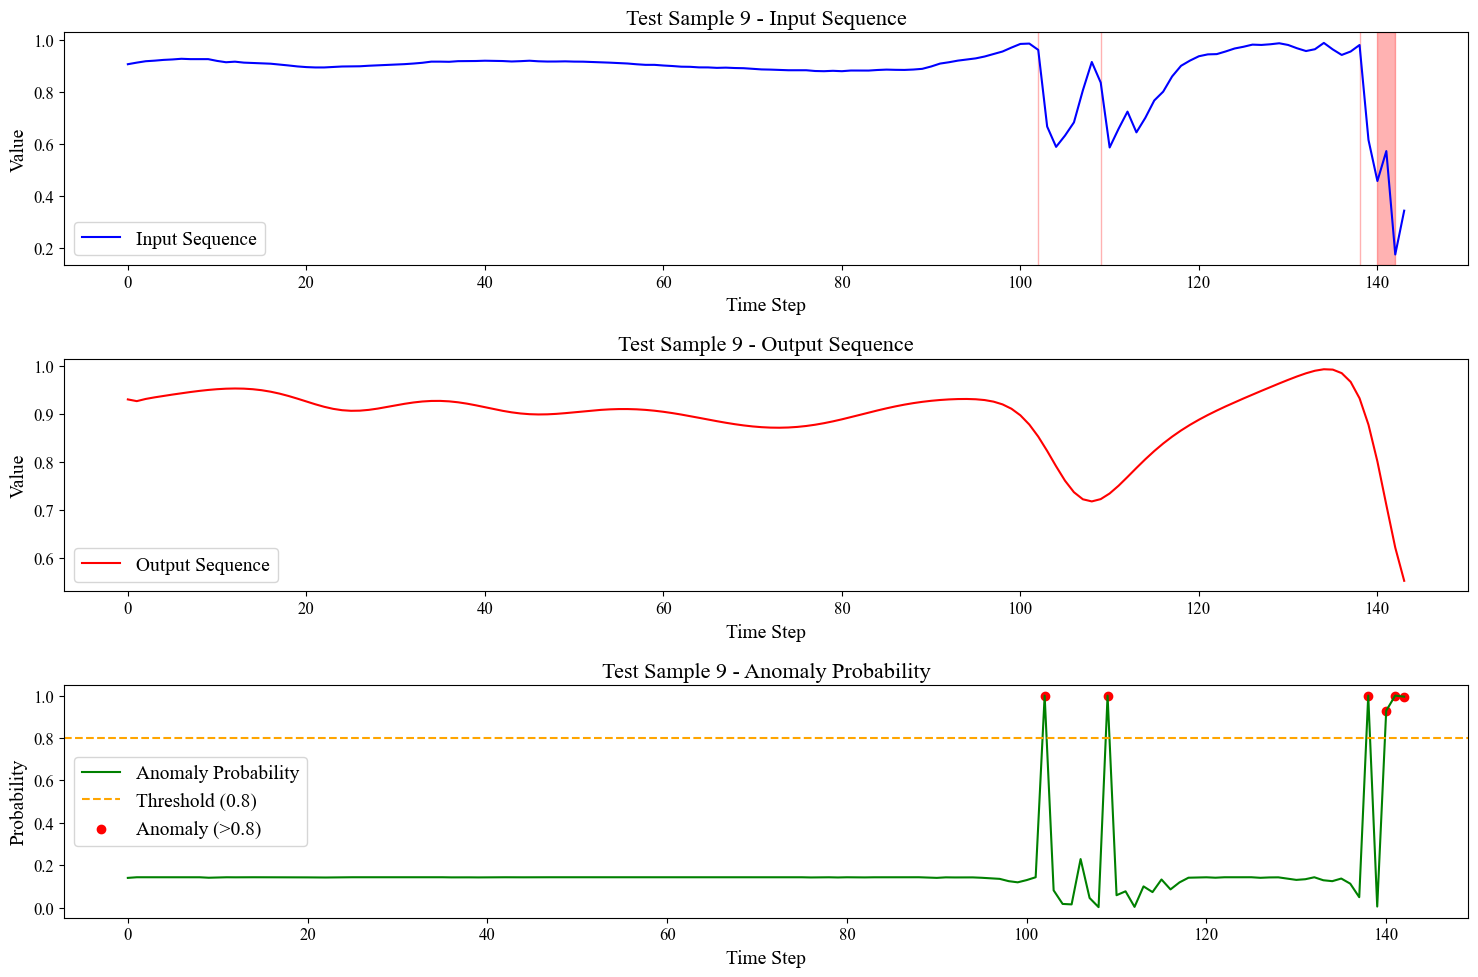

In [333]:
plot_result_A(8)

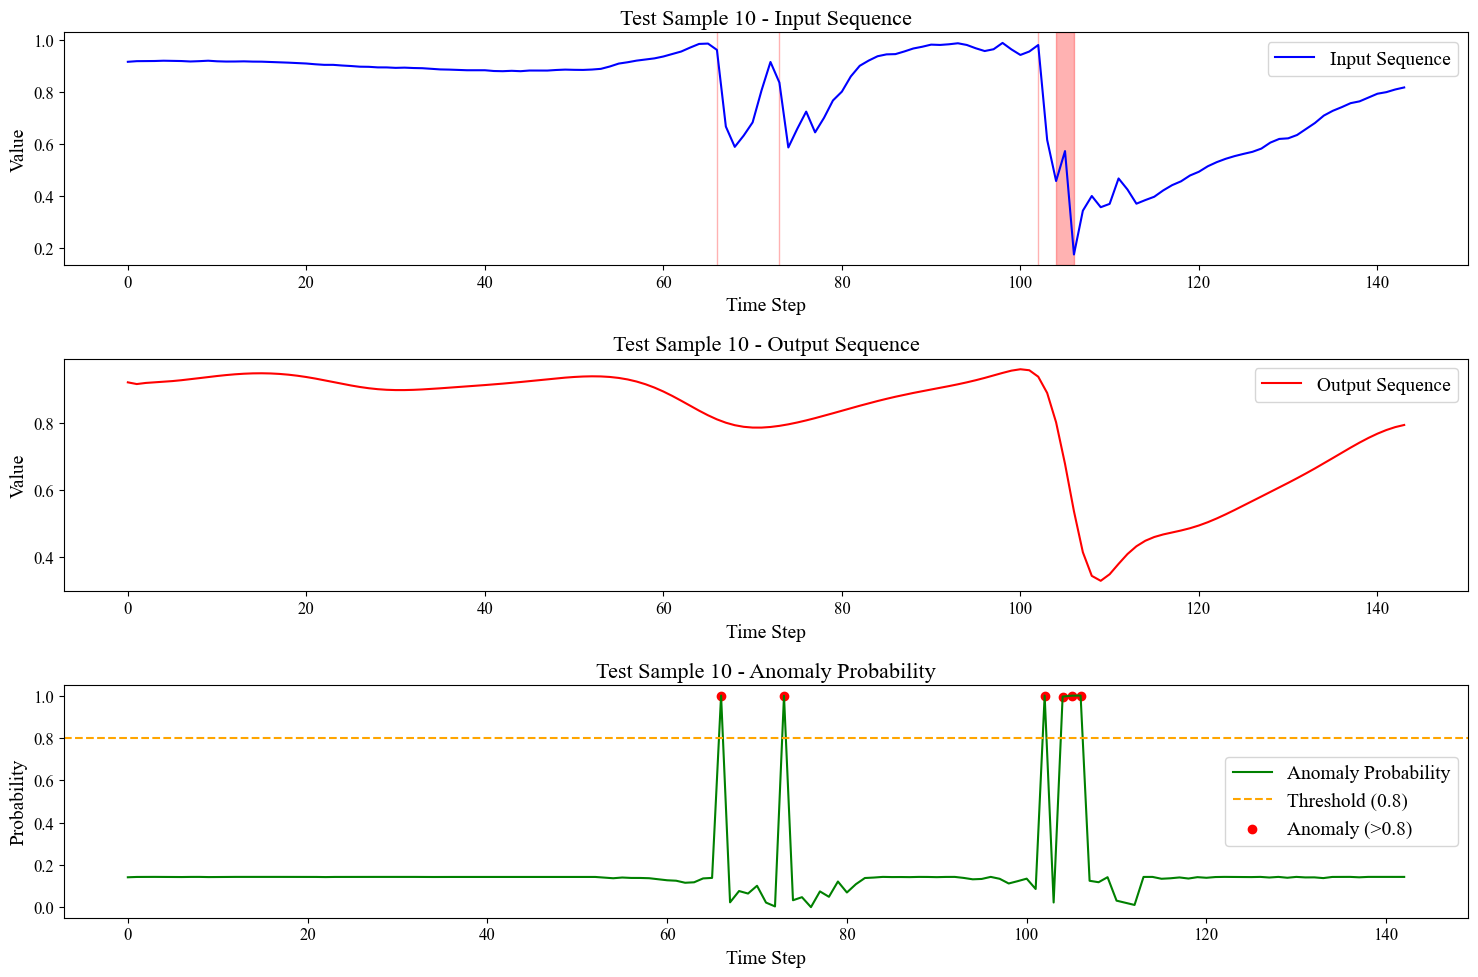

In [334]:
plot_result_A(9)

## II. Dataset B

In [ ]:
checkpoint_path_B = "checkpoint/ex2_1/epoch=92-val_loss=0.01.ckpt"
model_B = AutoencoderGRU_2.load_from_checkpoint(checkpoint_path_B)

## 测试1-1

In [222]:
def plot_error(ts1, ts2, error_limit):
    error = (ts1 - ts2)**2

    # 创建图形和子图
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # 绘制第一个子图
    axs[0].plot(ts1, label='Input')
    axs[0].plot(ts2, label='Output', linestyle='--')
    axs[0].set_title('Input and output comparison')
    
    # 标记误差超过许用误差的点
    over_tolerance = np.abs(error) > error_limit
    axs[0].scatter(np.where(over_tolerance), ts1[over_tolerance], color='red', label='Out of Tolerance (anormaly)')
    # axs[0].scatter(np.where(over_tolerance), ts2[over_tolerance], color='yellow', label='Out of Tolerance (TS2)')
    axs[0].legend(loc='upper right')

    # 绘制第二个子图
    axs[1].plot(error, color='red', label='Squared Error')
    axs[1].set_title('Reconstruction error')
    axs[1].axhline(y=error_limit, color='green', linestyle='--', label='Tolerance Threshold')
    axs[1].set_xlabel('Time Step')
    axs[1].set_ylabel('Squared Error')
    axs[1].legend(loc='upper right')

    # 显示整个图形
    plt.tight_layout()
    plt.show()

In [223]:
test_A_loader_288 = get_loader(data=test_A, batch_size=32, sub_length=288, ratio=0.75, shuffle=False)
test_B_loader_288 = get_loader(data=test_B, batch_size=32, sub_length=288, ratio=0.75, shuffle=False)

In [160]:
# seq_length=288
# embedding_dim = int(seq_length / 2)  # 嵌入向量的维度
# teacher_forcing_ratio = 0  # 教师强制比率

# checkpoint_path_1_1 = "checkpoint/ex1_1/epoch=89-val_loss=0.01.ckpt"
# model_1_1 = AutoencoderGRU_2.load_from_checkpoint(
#     checkpoint_path_1_1,
#     seq_length=seq_length,
#     input_dim=1,
#     embedding_dim=embedding_dim,
#     teacher_forcing_ratio=teacher_forcing_ratio
#     )

In [229]:
trainer = pl.Trainer()

# 使用 predict 方法对测试集进行推理
predictions = trainer.predict(model1_1, dataloaders=test_A_loader_288)

# `predictions` 是一个张量列表，可以转换为 numpy 数组或者进一步处理
predicted_values = [pred.detach().cpu().numpy() for pred in predictions]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
f:\conda_envs\torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting DataLoader 0:   0%|          | 0/7 [00:00<?, ?it/s]

Predicting DataLoader 0: 100%|██████████| 7/7 [00:01<00:00,  3.54it/s]


In [230]:
def plot_in_out(batch, sample):
    for i, data in enumerate(test_A_loader_288):
        if i == batch:
            # 假设 batch 是一个元组，包含 (data, target)
            x = data[0]
            x = x[sample]
            break

    pred = predicted_values[batch][sample]

    print(x.shape)
    print(pred.shape)
    plot_error(x.numpy(), pred, 0.1)

torch.Size([288, 1])
(288, 1)


ValueError: x and y must be the same size

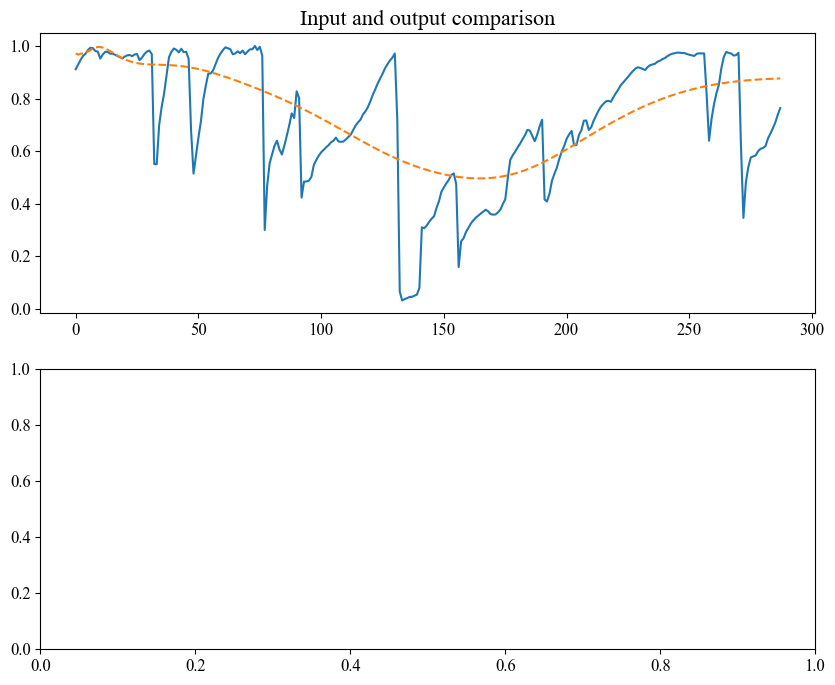

In [233]:
plot_in_out(2,7)

## 测试2-1

In [239]:
model_2_1.train_losses

[]

In [227]:
test_A_loader_144 = get_loader(data=test_A, batch_size=32, sub_length=144, ratio=0.75, shuffle=False)
test_B_loader_144 = get_loader(data=test_B, batch_size=32, sub_length=144, ratio=0.75, shuffle=False)

In [228]:
seq_length=144
embedding_dim = int(seq_length / 2)  # 嵌入向量的维度
teacher_forcing_ratio = 0  # 教师强制比率

checkpoint_path_2_1 = "checkpoint/ex2_1/epoch=93-val_loss=0.01.ckpt"
model_2_1 = AutoencoderGRU_2.load_from_checkpoint(
    checkpoint_path_2_1,
    seq_length=seq_length,
    input_dim=1,
    embedding_dim=embedding_dim,
    teacher_forcing_ratio=teacher_forcing_ratio,
    alpha=0.2
    )

RuntimeError: Error(s) in loading state_dict for AutoencoderGRU_2:
	size mismatch for encoder.gru1.weight_ih_l0: copying a param with shape torch.Size([216, 1]) from checkpoint, the shape in current model is torch.Size([432, 1]).
	size mismatch for encoder.gru1.weight_hh_l0: copying a param with shape torch.Size([216, 72]) from checkpoint, the shape in current model is torch.Size([432, 144]).
	size mismatch for encoder.gru1.bias_ih_l0: copying a param with shape torch.Size([216]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for encoder.gru1.bias_hh_l0: copying a param with shape torch.Size([216]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for encoder.gru2.weight_ih_l0: copying a param with shape torch.Size([108, 72]) from checkpoint, the shape in current model is torch.Size([216, 144]).
	size mismatch for encoder.gru2.weight_hh_l0: copying a param with shape torch.Size([108, 36]) from checkpoint, the shape in current model is torch.Size([216, 72]).
	size mismatch for encoder.gru2.bias_ih_l0: copying a param with shape torch.Size([108]) from checkpoint, the shape in current model is torch.Size([216]).
	size mismatch for encoder.gru2.bias_hh_l0: copying a param with shape torch.Size([108]) from checkpoint, the shape in current model is torch.Size([216]).
	size mismatch for decoder.gru1.weight_ih_l0: copying a param with shape torch.Size([108, 1]) from checkpoint, the shape in current model is torch.Size([216, 1]).
	size mismatch for decoder.gru1.weight_hh_l0: copying a param with shape torch.Size([108, 36]) from checkpoint, the shape in current model is torch.Size([216, 72]).
	size mismatch for decoder.gru1.bias_ih_l0: copying a param with shape torch.Size([108]) from checkpoint, the shape in current model is torch.Size([216]).
	size mismatch for decoder.gru1.bias_hh_l0: copying a param with shape torch.Size([108]) from checkpoint, the shape in current model is torch.Size([216]).
	size mismatch for decoder.gru2.weight_ih_l0: copying a param with shape torch.Size([216, 36]) from checkpoint, the shape in current model is torch.Size([432, 72]).
	size mismatch for decoder.gru2.weight_hh_l0: copying a param with shape torch.Size([216, 72]) from checkpoint, the shape in current model is torch.Size([432, 144]).
	size mismatch for decoder.gru2.bias_ih_l0: copying a param with shape torch.Size([216]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for decoder.gru2.bias_hh_l0: copying a param with shape torch.Size([216]) from checkpoint, the shape in current model is torch.Size([432]).
	size mismatch for decoder.output_layer.weight: copying a param with shape torch.Size([1, 72]) from checkpoint, the shape in current model is torch.Size([1, 144]).

In [234]:
trainer = pl.Trainer()

# 使用 predict 方法对测试集进行推理
predictions = trainer.predict(model2_1, dataloaders=test_A_loader_144)

# `predictions` 是一个张量列表，可以转换为 numpy 数组或者进一步处理
predicted_values = [pred.detach().cpu().numpy() for pred in predictions]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


In [235]:
def plot_in_out(batch, sample):
    for i, data in enumerate(test_A_loader_144):
        if i == batch:
            # 假设 batch 是一个元组，包含 (data, target)
            x = data[0]
            x = x[sample]
            break

    pred = predicted_values[batch][sample]

    print(x.shape)
    print(pred.shape)
    plot_error(x.numpy(), pred, 0.05)

torch.Size([144, 1])
(144, 1)


ValueError: x and y must be the same size

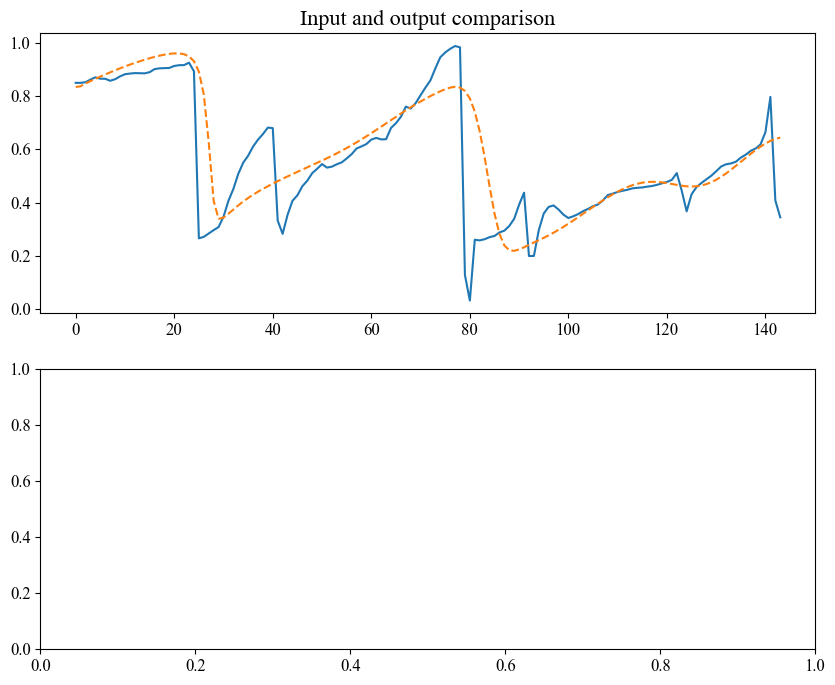

In [238]:
plot_in_out(1, 18)